# Advanced Statistic for Physics Analysis Project

- Chiara Maccani (2027591)
- Francesco Zambelli (2029014)
- Pietro Miglioranza (2029265)

The task of this work consists in the analysis of a dataset containing informations about cardiovascular disease [1].  It is made of 70 000 records of patients data composed by 11 features and a target indicating the presence or absence of the disease.  After having done some preliminary data manipulation, the main goal of the project is to build the best classification predictive model using Bayesian Networks. In order to find the most probable belief-network structure, the K2 algorithm [2] is implemented and used.  The results in terms of accuracy of the predictions are compared to other classification models such as decision trees. 

## Libraries

In [ ]:
library(tidyverse)
library(bnlearn)
library(Rgraphviz)
library(curl)
library(caret)
library(randomForest)
library(gtools)
library(ROCR)
library(rpart)
library(rpart.plot)
library(rattle)

options(warn=-1)

## Dataset

The dataset we use is composed by a set of information related to cardiovascular desease, consituted of 70000 records. It was found on Kaggle ([1] https://www.kaggle.com/sulianova/cardiovascular-disease-dataset). 

The features can be divided in 3 main groups:

- Objective: factual information;
- Examination: results of medical examination;
- Subjective: information given by the patient.

They are:

1. **Age** | $\color{#BF616A}{Objective\: Feature}$ | **age** | int (days)
2. **Height** | $\color{#BF616A}{Objective\: Feature}$| **height** | int (cm) |
3.  **Weight** | $\color{#BF616A}{Objective\: Feature}$ | **weight** | float (kg) |
4.  **Gender** | $\color{#BF616A}{Objective\: Feature}$ | **gender** | categorical code |
5.  **Systolic blood pressure** | $\color{#A3BE8C}{Examination\: Feature}$ | **ap_hi** | int |
6.  **Diastolic blood pressure** | $\color{#A3BE8C}{Examination\: Feature}$ | **ap_lo** | int |
7.  **Cholesterol** | $\color{#A3BE8C}{Examination\: Feature}$ | **cholesterol** | 1: normal, 2: above normal, 3: well above normal |
8.  **Glucose** | $\color{#A3BE8C}{Examination\: Feature}$ | **gluc** | 1: normal, 2: above normal, 3: well above normal |
9.  **Smoking** | $\color{#B48EAD}{Subjective\: Feature}$ | **smoke** | binary |
10.  **Alcohol intake** | $\color{#B48EAD}{Subjective\: Feature}$ | **alco** | binary |
11. **Physical activity** | $\color{#B48EAD}{Subjective\: Feature}$ | **active** | binary |
12.  **Presence or absence of cardiovascular disease** | $\color{#EBCB8B}{Target\: Variable}$ | **cardio** | binary |

One more feature was appended to the previous one:

13. **Age** | $\color{#BF616A}{Objective\: Feature}$ | **age_year** | int (years)|

It was calculated as  $\text{int}(age/365)$

In [ ]:
#Loading the dataset
id1 <- "1gBl5Y8AtNsLHH7EOQLXspZ4Ddgc85oRc"
id2 <- "1-nWRmXhj10tDPiGGnvjIIz8uZaQS9ahk"
sURL1 <- curl(sprintf("https://docs.google.com/uc?id=%s&export=download", id1))
sURL2 <- curl(sprintf("https://docs.google.com/uc?id=%s&export=download", id2))
data <- read.csv(sURL1, sep=';', head=TRUE, colClasses = "numeric")
data.cat  <- read.csv(sURL2, sep=',', head=TRUE, stringsAsFactors = TRUE)

In [ ]:
#Displaying the first 10 lines of the dataset
col.names <- colnames(data.cat)
head(data)
head(data.cat)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,18393,2,168,62,110,80,1,1,0,0,1,0
2,1,20228,1,156,85,140,90,3,1,0,0,1,1
3,2,18857,1,165,64,130,70,3,1,0,0,0,1
4,3,17623,2,169,82,150,100,1,1,0,0,1,1
5,4,17474,1,156,56,100,60,1,1,0,0,0,0
6,8,21914,1,151,67,120,80,2,2,0,0,0,0


,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,Female,Medium,Medium,Normal,HBP stage1,Normal,Normal,No,No,Yes,No,40-50
2,Male,Small,Heavy,HBP stage2,HBP stage2,Well above normal,Normal,No,No,Yes,Yes,50-60
3,Male,Medium,Medium,HBP stage1,Elavated,Well above normal,Normal,No,No,No,Yes,50-60
4,Female,Medium,Heavy,HBP stage2,HBP stage2,Normal,Normal,No,No,Yes,Yes,40-50
5,Male,Small,Light,Normal,Normal,Normal,Normal,No,No,No,No,40-50
6,Male,Small,Medium,Elavated,HBP stage1,Above normal,Above normal,No,No,No,No,50-60


### Data Correction
By inspecting the dataset we noticed that some values that the varibles $\textit{ap_lo}$ or $\textit{ap_hi}$ assumed were clearly wrong (as negative values, which cannot occour if we are treating with blood pressure measurament), so we try to infer the type of the error and to corrected them by means of the ***`data_corr( )`* function**.

In [ ]:
data_corr <- function(name,data){
    res <- c()
    if (name=='ap_hi') {
        for (d in data[[name]]) {
            if (d<30 & d>5) {
                res <- c(res, d*10)
            } else if (d<0) {
                res <- c(res, -d)
            } else if (d>500 & d <5000) {
                res <- c(res, d/10)
            } else if (d>5000) {
                res <- c(res, d/100)
            } else {
                res <- c(res,d)
            }
        }
    }
    
    if (name=='ap_lo') {
        for (d in data[[name]]) {
            if (d<30 & d>5) {
                res <- c(res, d*10)
            } else if (d<0) {
                res <- c(res, -d)
            } else if (d>500 & d <5000) {
                res <- c(res, d/10)
            } else if (d>5000) {
                res <- c(res, d/100)
            } else {
                res <- c(res,d)
            }
        }
    }
    return(res)
}

In [ ]:
#Correct wrong values of ap_hi and ap_lo
data <- mutate(data, age_year=round(age/365,0))
for (n in c("ap_hi", "ap_lo")) {
    data[[n]] <- data_corr(n, data)
}

### Data Visualization

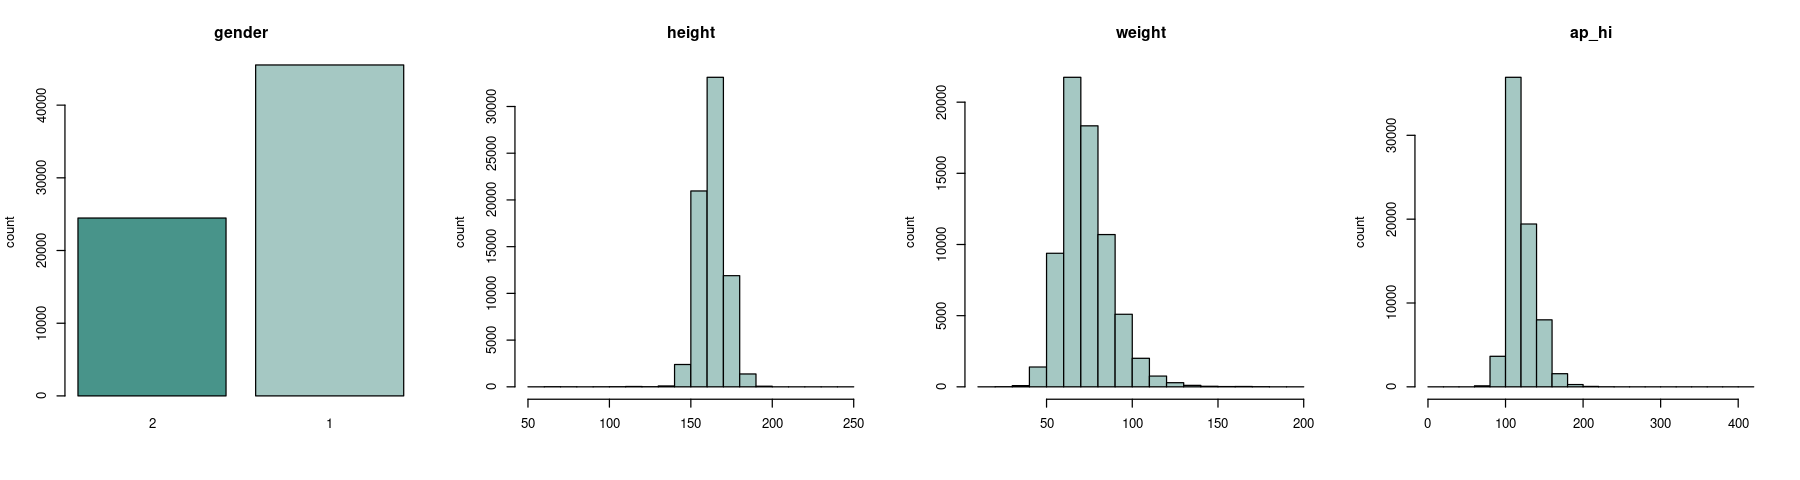

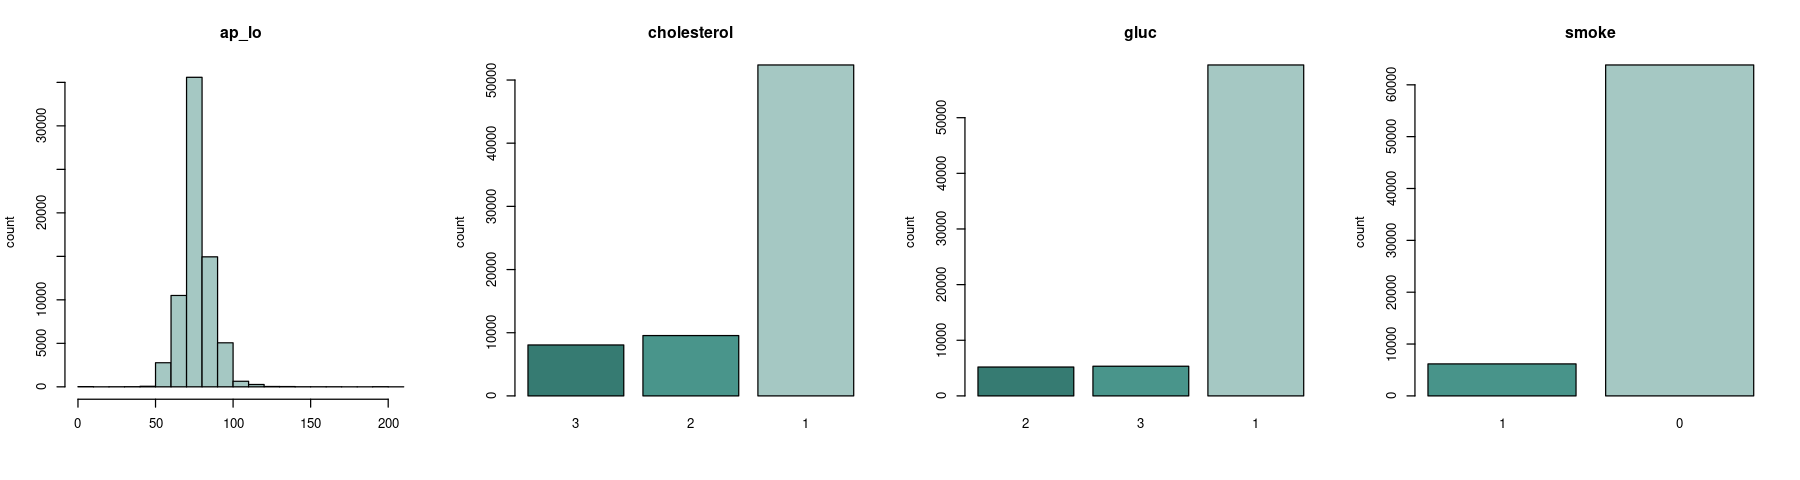

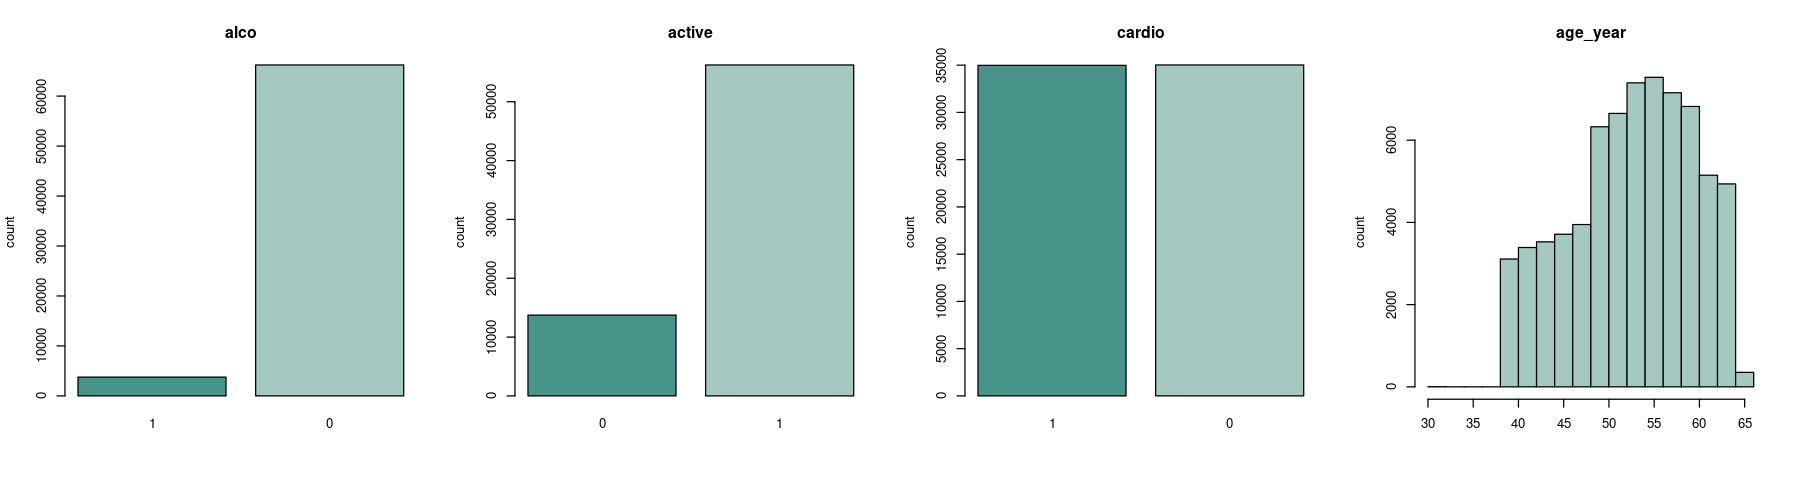

In [ ]:
#Plot histograms of all the features
options(repr.plot.width=15, repr.plot.height=4)

data.train <- data[col.names]

par(mfrow = c(1,4))

for (i in 1:length(col.names)) {
    if (length(table(data.cat[[col.names[i]]]))==2){
        colors <- c('#48948a','#a5c8c3')
    }
    else if (length(table(data.cat[[col.names[i]]]))==3){
        colors <- c('#367b72','#49958b','#a5c8c3')
    }
    
    if (col.names[i] %in% c('height', 'weight', 'ap_hi', 'ap_lo', 'age_year')) {
        hist(data.train[[col.names[i]]], main=col.names[i],
             ylab='count', col='#a5c8c3',xlab='')
    } else {
        barplot(table(data.train[[col.names[i]]])[order(table(data.train[[col.names[i]]]))],
                col= colors,
        ylab="count",
        main=col.names[i])
  }

}

As it is possible to see from the above graphics we are dealing with a hybrid dataset i.e. with both categorical and continuous variables. In order to get a categorical dataset and perform our analysis we have to split into categories those variables that are continuous: this conversion is made through the ***`categ.conv( )`* function**.\
The *`categ.conv( )`* function splits each continuous feature in a small number (2,3 or 4) of possible discrete named values. Once this categorization has been done we converted every dataset column in factor type (needed for the use of bnlearn functions).\
It's important to notice that we perform this operation once and saved the cathegorical dataset in a new file which we load at the beginning of the notebook. In the following we report the ***`categ.conv( )`* function**.

In [ ]:
categ.conv <- function(name, data) {
    outp <- c()
    if (name=="gender") {
        for (d in data[[name]]) {
            if (d==1) {
                outp <- c(outp,'Male')
            }
            else {
                outp <- c(outp,'Female')
            }
        }
    }
    
    else if (name=="height") {
        for (d in data[[name]]) {
            if (d<165) {
                outp <- c(outp,'Small')
            }
            else if (d>180){
                outp <- c(outp,'Tall')
            }
            else {
                outp <- c(outp, 'Medium')
            }
        }
    }
    
    else if (name=="weight") {
        for (d in data[[name]]) {
            if (d<60) {
                outp <- c(outp,'Light')
            }
            else if (d>80){
                outp <- c(outp,'Heavy')
            }
            else {
                outp <- c(outp, 'Medium')
            }
        }
    }
    
    else if (name=="ap_lo") {
        for (d in data[[name]]) {
            if (d<70) {
                outp <- c(outp,'Light')
            }
            else if (d>=70 & d<80){
                outp <- c(outp,'Elavated')
            }
            else if (d>=80 & d<90) {
                outp <- c(outp, 'HBP stage1')
            }
            else if (d>=90 & d <120) {
                outp <- c(outp, 'HBP stage2')
            }
            else {
                outp <- c(outp, 'Hypertensive')
            }
        }
    }
    
    else if (name=="ap_hi") {
        for (d in data[[name]]) {
            if (d<120) {
                outp <- c(outp,'Light')
            }
            else if (d>=120 & d<130){
                outp <- c(outp,'Elavated')
            }
            else if (d>=130 & d<140) {
                outp <- c(outp, 'HBP stage1')
            }
            else if (d>=140 & d <180) {
                outp <- c(outp, 'HBP stage2')
            }
            else {
                outp <- c(outp, 'Hypertensive')
            }
        }
    }
    
    else if (name=="cholesterol" || name=="gluc") {
        for (d in data[[name]]) {
            if (d==1) {
                outp <- c(outp,'Normal')
            }
            else if (d==2){
                outp <- c(outp,'Above normal')
            }
            else if (d==3) {
                outp <- c(outp, 'Well above normal')
            }
        }
    }
    
    else if (name=="smoke" || name=="alco" || name=='active' || name=='cardio') {
        for (d in data[[name]]) {
            if (d==0) {
                outp <- c(outp,'No')
            }
            else if (d==1){
                outp <- c(outp,'Yes')
            }
        }
    }
    
    else if (name=="age_year") {
        for (d in data[[name]]) {
            if (d<=35) {
                outp <- c(outp,'Young')
            }
            else if (d>35 & d<=60){
                outp <- c(outp,'Adult')
            }
            else if (d>60 & d<=80) {
                outp <- c(outp,'Retired')
            }
            else {
                outp <- c(outp,'Old')
            }
        }
    }
    
    return(outp)
}

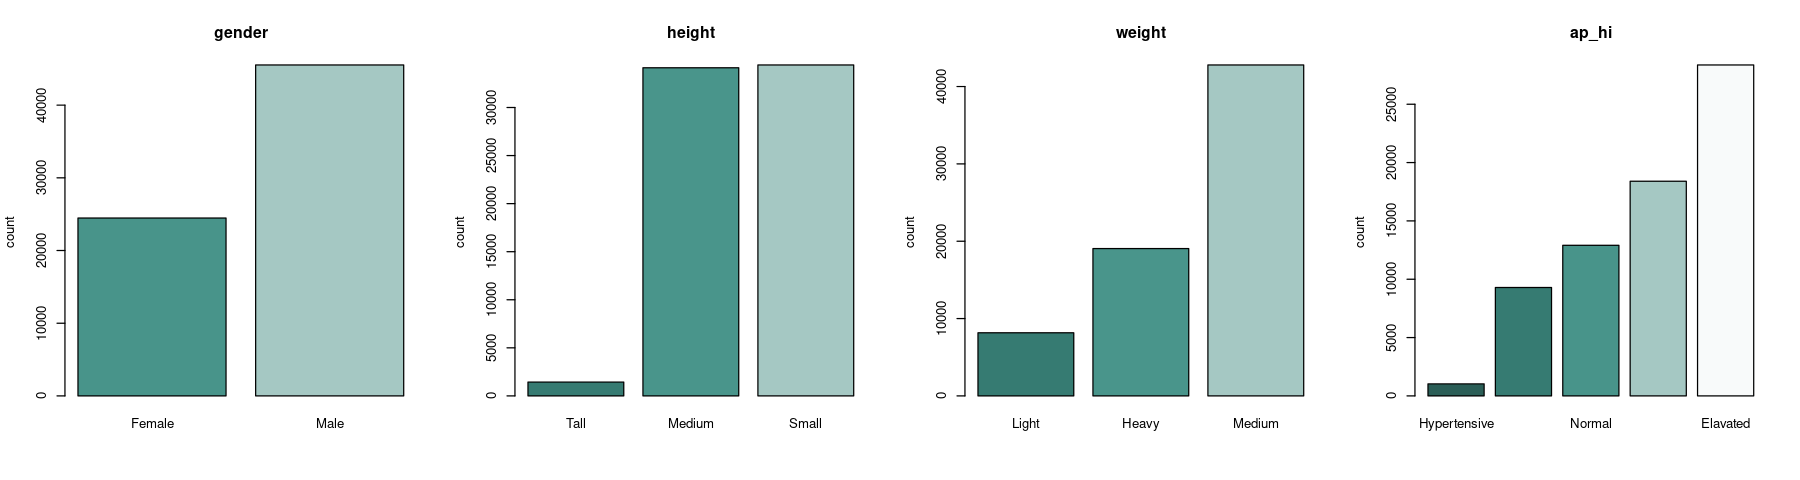

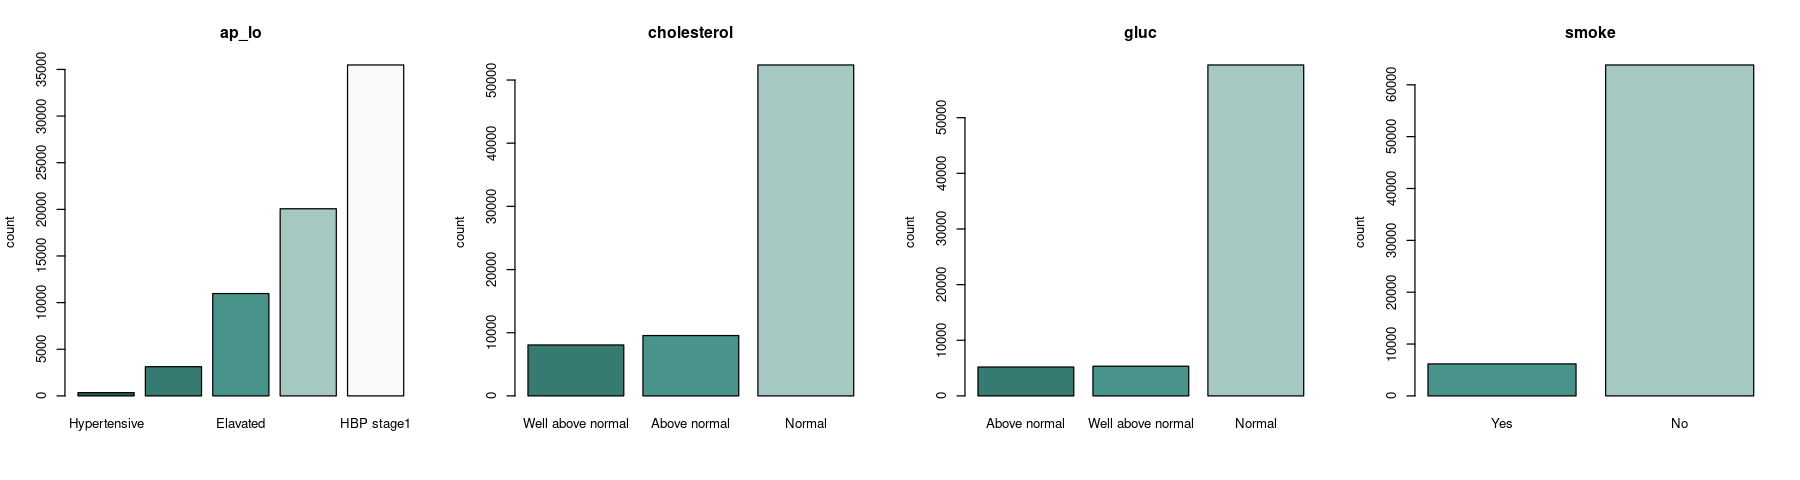

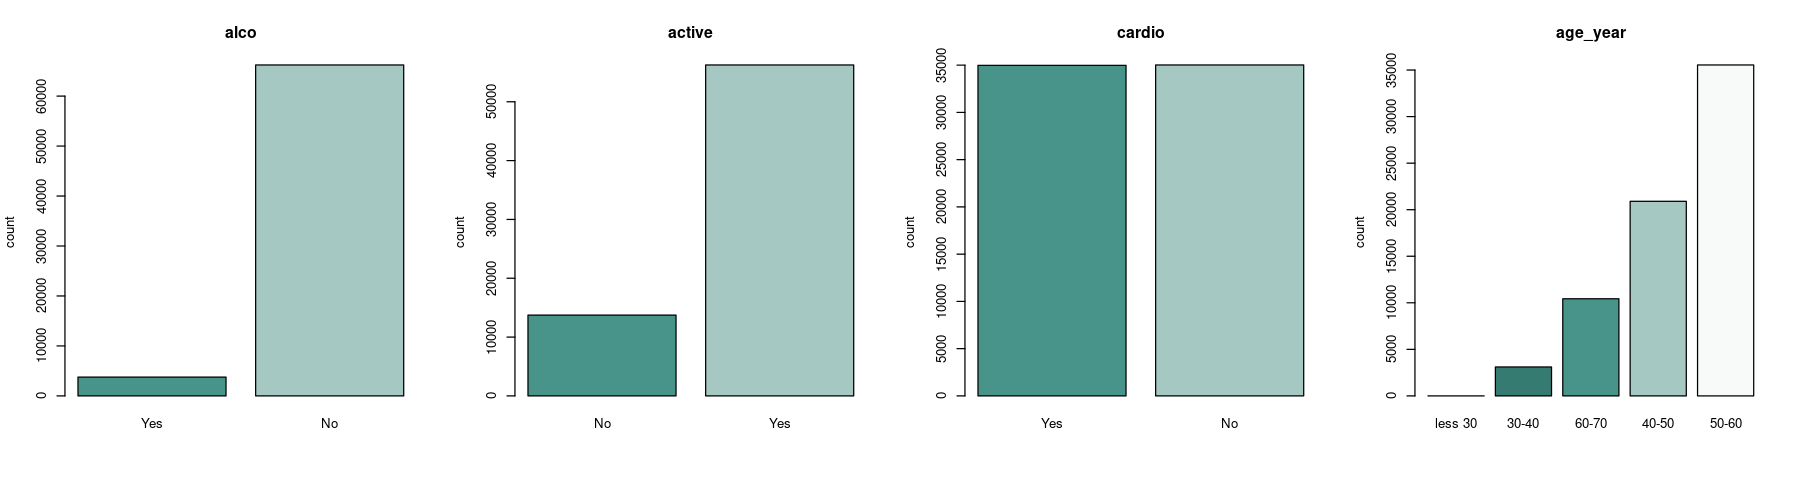

In [ ]:
#Plot histograms of all the features
options(repr.plot.width=15, repr.plot.height=4)

par(mfrow = c(1,4))

for (i in 1:length(col.names)) {
    if (length(table(data.cat[[col.names[i]]]))==2){
        colors <- c('#48948a','#a5c8c3')
    }
    else if (length(table(data.cat[[col.names[i]]]))==3){
        colors <- c('#367b72','#49958b','#a5c8c3')
    }
    else if (length(table(data.cat[[col.names[i]]]))==4){
        colors <- c('#2b5e57','#367b72','#48948a','#a5c8c3')
    }
    else if (length(table(data.cat[[col.names[i]]]))==5){
        colors <- c('#2b5e57','#367b72','#48948a','#a5c8c3','#f8fafa')
    }
  barplot(table(data.cat[[col.names[i]]])[order(table(data.cat[[col.names[i]]]))],
      col= colors,
      ylab="count",
      main=col.names[i])

}

## Bayesian Network
Bayesian Networks are definined by:
- A network structure, i.e. a direct acyclic graph $\mathcal{G}(V,A)$ in which each node $v_j\in V$ corresponds to a random variable $X_j \in X$
- A global probability distribution $P(X)$ which can be factorized as:  \begin{equation} P(X) = \prod_{j=1}^N P(X_j|\Pi_{X_j}) \end{equation}
where $\Pi_{X_j}$ are the parents of $X_j$.

The first component of a Bayesian Network is a Directed Acyclic Graph:
A Graph $\mathcal{G}$ is a mathematical object with:
- A set of nodes $V=\{v_1,...,v_N\}$
- A set of archs $A$ which are identified by pairs for nodes in $V$: $\mathcal a_{ij}=(v_i,v_j)$

Given a set of nodes $V$, a Graph is uniquely identified by $A$.\
In Particular a Directed Acyclic Graph (DAG) is a graph that:
- Contains only directed arcs, i.e. given $(v_i,v_j)\neq(v_j,v_i)$ an ordered pair of nodes, the arc $a_{ij}$ as a specific direction
- Does not contain any loop (for instance an arc $v_i\to v_i$ from a node to itself)
- Does not contain any cycle (for instance a sequence of arcs $v_i \to v_j \to...\to v_k \to v_i $ that starts and ends in the same node).

Concerning the Probability distribution we know from a proposition that any joint probability distribution $P(X) = \prod_{j=1}^N P(X_j|\Pi_{X_j})$ may be represented by a BN where we denote as $X_j$ parents $\Pi_j$ the set of variables $X_k$ such that there is an arc $X_k \to X_j$

### Self-made network structure
Guessing the correct structure of Bayesian Network is a complex task and requires some knowledge about the dataset variables relationships. In the following we report the net we built based on our belief about variables connections.

In [ ]:
obj.feature <- c('age_year','height','weight','gender')
ex.feature <- c('ap_hi','ap_lo','cholesterol','gluc')
sub.feature <- c('smoke','alco','active')
target <- 'cardio'

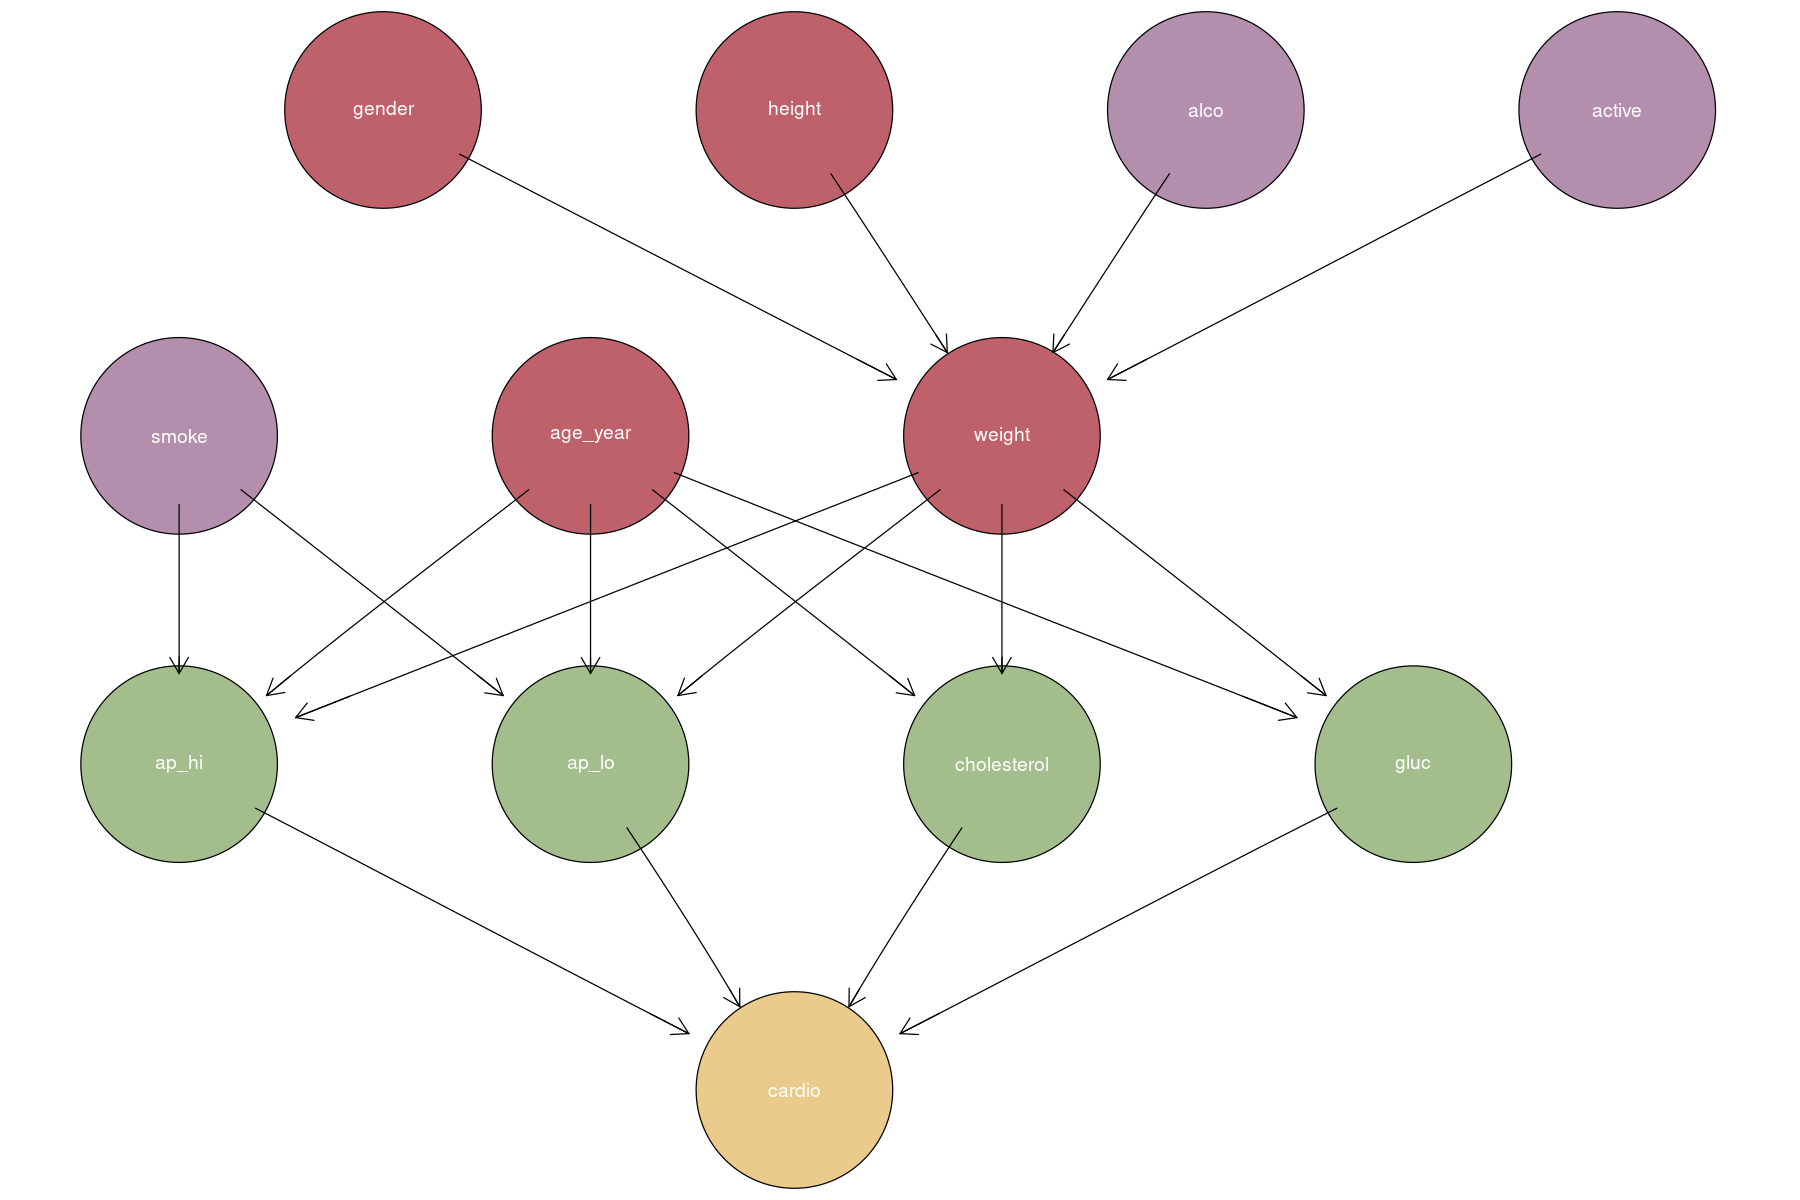

In [ ]:
tus_dag <- empty.graph(nodes = col.names)

tus_dag <- set.arc(tus_dag, from = "active", to = "weight")
tus_dag <- set.arc(tus_dag, from = "alco", to = "weight")
tus_dag <- set.arc(tus_dag, from = "gender", to = "weight")
tus_dag <- set.arc(tus_dag, from = "height", to = "weight")

tus_dag <- set.arc(tus_dag, from = "weight", to = "cholesterol")
tus_dag <- set.arc(tus_dag, from = "weight", to = "gluc")
tus_dag <- set.arc(tus_dag, from = "weight", to = "ap_lo")
tus_dag <- set.arc(tus_dag, from = "weight", to = "ap_hi")

tus_dag <- set.arc(tus_dag, from = "age_year", to = "cholesterol")
tus_dag <- set.arc(tus_dag, from = "age_year", to = "gluc")
tus_dag <- set.arc(tus_dag, from = "age_year", to = "ap_lo")
tus_dag <- set.arc(tus_dag, from = "age_year", to = "ap_hi")

tus_dag <- set.arc(tus_dag, from = "smoke", to = "ap_lo")
tus_dag <- set.arc(tus_dag, from = "smoke", to = "ap_hi")

tus_dag <- set.arc(tus_dag, from = "cholesterol", to = "cardio")
tus_dag <- set.arc(tus_dag, from = "gluc", to = "cardio")
tus_dag <- set.arc(tus_dag, from = "ap_lo", to = "cardio")
tus_dag <- set.arc(tus_dag, from = "ap_hi", to = "cardio")

options(repr.plot.width=15, repr.plot.height=10)
pp <- graphviz.plot(tus_dag,render=FALSE)
nodeRenderInfo(pp) = list(col= 'black',
                          textCol = 'white',
                          fill = c('age_year'='#BF616A',
                                    'height'='#BF616A',
                                    'weight'='#BF616A',
                                    'gender'='#BF616A',
                                    'ap_hi'='#A3BE8C',
                                    'ap_lo'='#A3BE8C',
                                    'cholesterol'='#A3BE8C',
                                    'gluc'='#A3BE8C',
                                    'smoke'='#B48EAD',
                                    'alco'='#B48EAD',
                                    'active'='#B48EAD',
                                    'cardio'='#EBCB8B'),
                          fontsize= 17)
renderGraph(pp)

### Analyzing a DAG structure from data
When we do not know the underlying structure of a BN we can evaluate our proposal DAG by means of two different classes of statictical criteria:
- The conditional indipendence test
- The network scores

The first statistical criterion analyze the single connections between nodes: in particular they are used to verify that the probabilostic dependence encoded by a specific arc is well supported by the data.\
Network scores instead focus on the DAG as a whole and provide a statistical measurement of how well the Graph mirrors the dependence structure of the data.\
Within the ```bnlearn``` library are available several scores through which is possible to compare different DAGs.

### Indipendence tests
An indipendence test is a test that determinates if two variables are indipendent or not. The null hypotesis states that they are indipendent, while the alternative one that they are not indipendent. In `bnlearn` this kind of tests are implemented within the function `ci.test`, that can use many different test statisitcs ($\chi^2$, $MI$, $JT$, $ZF$...); in our case we used the Mutual Information ($MI$), which is computed as the $\textit{log-likelihood ratio $G^2$}$:

\begin{equation}
P(V_1,V_2|V_3,V_4)=\sum_{v_1\in V_1}\sum_{v_2\in V_2}\sum_{k\in V_3\times V_4}n_{v_1v_2k}\log\frac{n_{v_1v_2,k}n_{++k}}{n_{v_1+k}n_{+v_2k}}
\end{equation}

where "+" subscript denotes the sum over that index.

In the following piece of code is implemented a function which performs an indipendency test over all the arcs of a network given a dataset relying on the `bnlearn::ci.test()`function. Further **conditional** indipendence test can be done by exploiting the ```ci.test()``` function for single connections by hand, specifying some conditioning variables within the arguments.

In [ ]:
indipendence.test<- function(dag,data,type='categorical',graph=FALSE){
    if (type=='categorical'){
        test = 'mi'
        title = 'Mutual Information'
    }
    else if (type=='continuous'){
        test = 'mi-g'
        title = 'Mutual Infomation-Gaussian'
    }
    mi <- rep(0,nrow(dag$arcs))
    p.value <- rep(0,nrow(dag$arcs))
    arc <- rep('a',nrow(dag$arcs))
    for (i in 1:nrow(dag$arcs)){
        ci <- ci.test(dag$arcs[i,1],dag$arcs[i,2],test=test,data=data)
        mi[i] <- ci[[1]]
        p.value [i] <- ci[[2]]
        arc[i] <- ci$data.name
        
    }
    res <- tibble(arc,mi,p.value)
    if(graph){
        order<- order(res[[2]],decreasing = TRUE)
        ordered <- res[order,]
        options(repr.plot.width=8, repr.plot.height=6)
        par(mar=c(2,7,1,1))
        barplot(head(ordered[[2]],10),names=head(ordered[[1]],10),
        las=1,cex.names=0.8,main=title,col='#49958b',horiz=TRUE)
        return(res)
    }
    else{
        return(res)   
    }
    
}

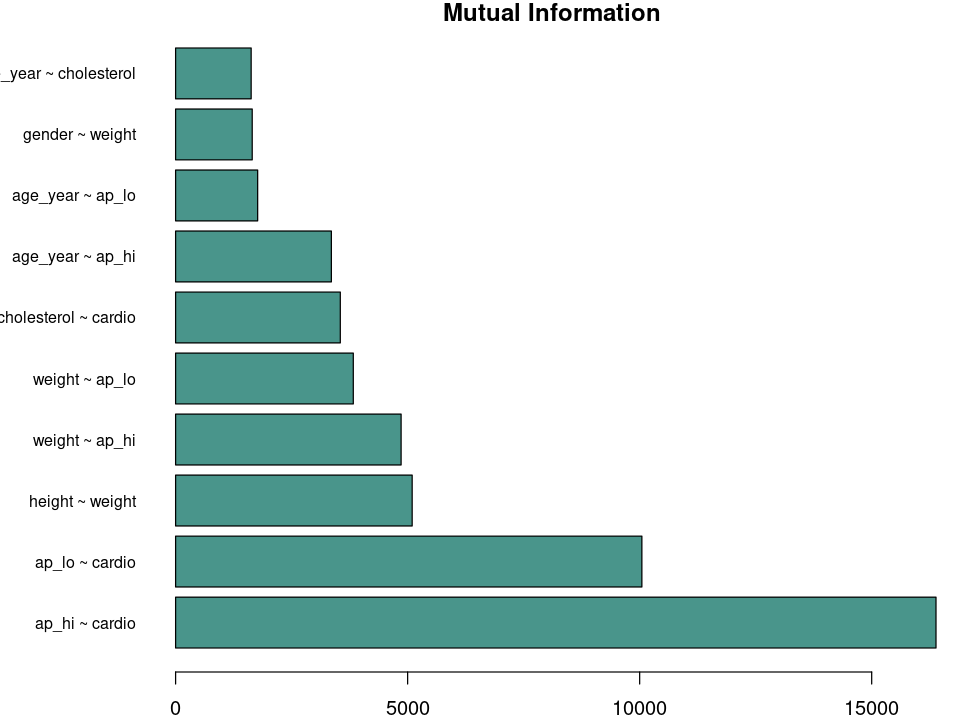

In [ ]:
tus_dag_test <- indipendence.test(tus_dag,data.cat,graph= TRUE)

### Network scores
Within the ```bnlearn``` packages are implemented several scores: in particular in this work in order to compare the network we use the ```K2``` score which is:
\begin{equation} Score_{K2}(G,D)=\log\bigg(P(G)\prod_{i=1}^n\prod_{j=1}^{q_i}\dfrac{(r_i-1)!}{(N_{ij}+r_i-1)!}\prod_{K=1}^{ri}\alpha_{ijk}!\bigg) \end{equation}

where the variables are described in the paragraph below.

In [ ]:
score_tus_dag <- bnlearn::score(tus_dag, data.cat, type='k2')
cat(sprintf("K2 score of the network: %.4f",score_tus_dag))

K2 score of the network: -605573.9730

### Joint Probability table Estimation
We said that a BN is defined by:
- A DAG 
- A probability density function $P(X) = \prod_{j=1}^N P(X_j|\Pi_{X_j})$

Then, once the network structure is known, the only thing to do is to estimate the joint probabilities.\
In order to find the probability values that describe the connection between the features, the ```bnlearn``` package gives a ```fit``` function that provides this task.

There are 2 methods that can be used:
1. ```mle```: it calculates the Maximun Likelihood estimate of the parameters. In practise it counts the conditional frequencies of events that belong to the same feature with respect to the values assumed by the parents nodes.

2. ```bayes```: posteriors are estimated from the data, using as conjugate priors for computational efficiency reasons. In particular for descreate cases the Dirichlet distribution is used:
\begin{equation} 
Dir(\alpha_{k|\prod_{X_i}=\pi})\rightarrow data \rightarrow Dir(\alpha_{k|\prod_{X_i}=\pi} +n_{k|\prod_{X_i}=\pi})
\end{equation}

meaning that $\hat{p}_{k|\prod_{X_i}=\pi}=\frac{\alpha_{k|\prod_{X_i}=\pi}}{\sum_{\pi} \alpha_{k|\prod_{X_i}=\pi}}$

The only free parameter is the equivalent or imaginary sample size (```iss```), which gives the relative weight of the prior compared to the observed sample.

In [ ]:
tus_dag_fitted <- bn.fit(tus_dag,data.cat,method = 'mle')

Once the DAG have been fitted we have a complete bayesian network: then we can for instance display all the joint probabilities for a given node in order to investigate variables relationships:

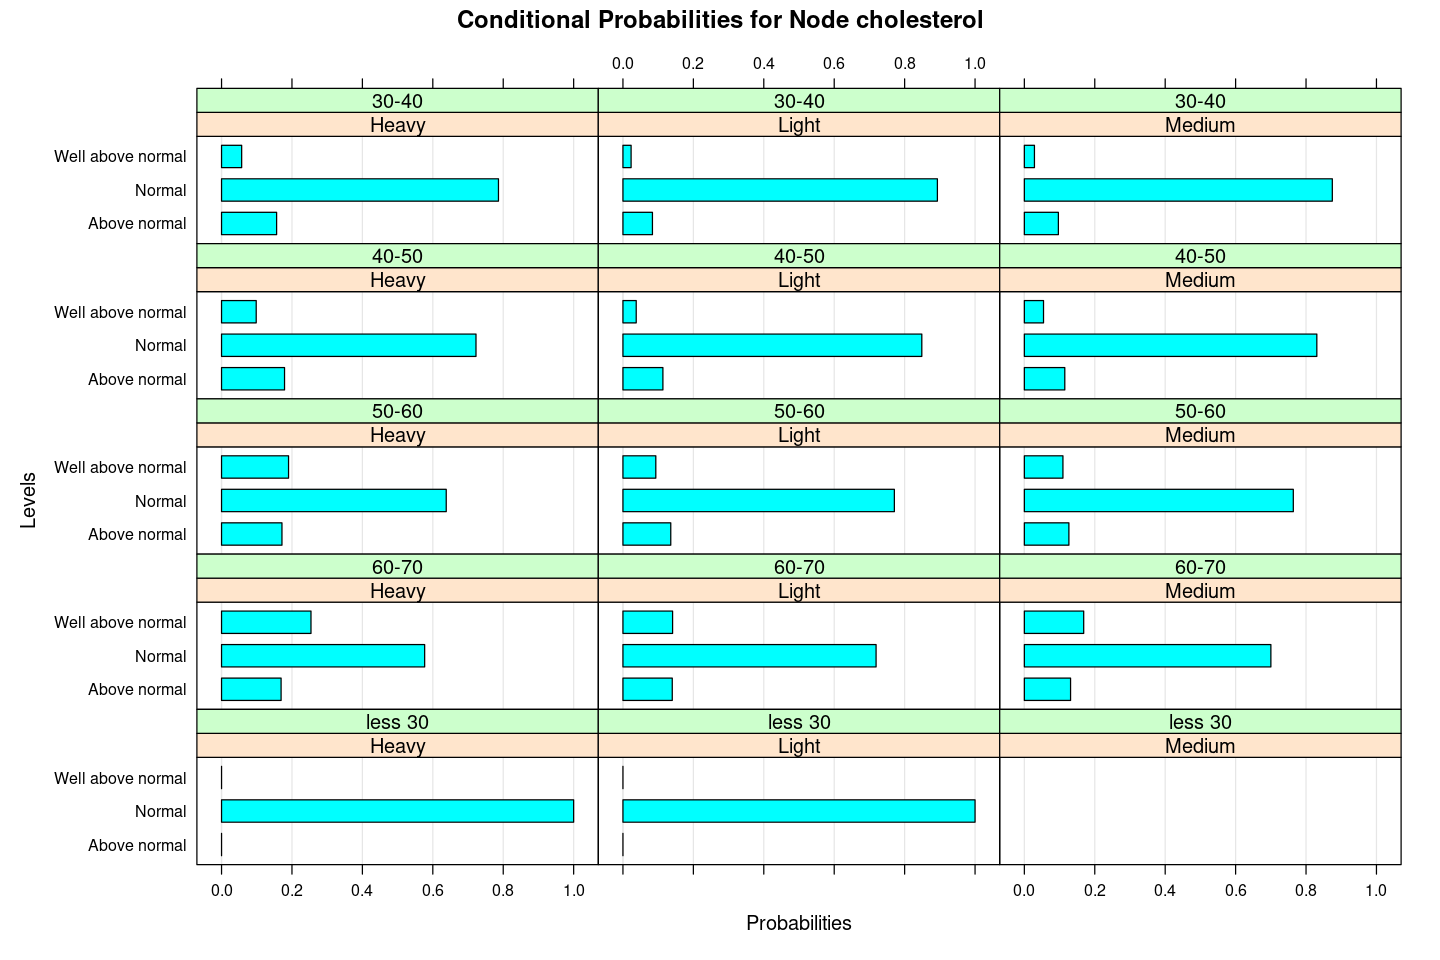

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)
bn.fit.barchart(tus_dag_fitted$cholesterol)

## K2 Algorithm
As we said before guessing the correct Network structure requires knolwedge about variables and their connection. Then what if we infer the Network Structure from the data?\
Inferring Bayesian network structure from data is a challanging issue: the space of the possible DAGs is discrete and finite, moreover it grows exponentially with the number of nodes. Then in order to explore the space of all the possible DAG structures ad-hoc algorithm are required.\
\
Three well-known methods to learn the structure of BNs are:
- Constraint based methods
- Score based methods
- Hybrid approaches 

In particular when we talk about score-based methods we cosider methods that attempt to select a DAG skeleton that maximizes the selected scoring-function which is characterized as a *measure of fitness between the selected structure and the available dataset*. In practice this kind of methods utilizes a given scoring function in combination with a search method in order to evaluate the degrees of fitness of each selected structure from the space of the feasible solutions: in particular in the search procedure is found the DAG skeleton $G^*$ among all $K(n)$ possible DAGs such that the scoring function $g(G:D)$ is maximum:

\begin{equation} G^* = \mbox{arg}\max_{G \in K(n)}g(G:D) \end{equation}

The K2 algorithm is a well established and efficent score-based method for finding the relative probabilities of different belief-network structures. In particular it seeks for the bayesian network structure $G^*$ given a dataset D with maximal $P(G^*|D)$, where $P(G|D)$ is the probability of the network structure $G$ given the dataset $D$. Then in this case the algorithm seeks to:

\begin{equation}G^* = \arg\max_{G \in K(n)}P(G|D) \end{equation}.

Given the fact that for a given dataset D it holds that $P(G|D)\propto P(G,D)$ we can compute $\text{argmax } P(G,D)$ instead of $\text{argmax } P(G|D)$; and if we assume that:

1. The dataset variables are categorical
2. Given a belief network model records occur indipendently
3. There are no records with missing entries
4. The pdf $P(G|A)$ is uniform

then $P(G,D)$ can be computed by:

\begin{equation} P(G,D)=P(G)\prod_{i=1}^n\prod_{j=1}^{q_i}\dfrac{(r_i-1)!}{(N_{ij}+r_i-1)!}\prod_{K=1}^{ri}\alpha_{ijk}! \end{equation}

where:
- $P(G)$ = prior probability of $G$
- $n$ = # of variables $X_i \in X$
- $q_i$ = # of possible unique instantiations $\mathcal{w_{ij}}$ of the parents $\pi_i$ of the node $X_i$
- $r_i$ = # of possible values $\mathcal{v_{ik}}$ of the variable $X_i$
- $\alpha_{ijk}$ = # number of cases in D in which the variable $X_i$ has the value $\mathcal{v_{ik}}$ and $\pi_i$ is instantiated as $\mathcal{w_{ij}}$
- $N_{ij}= \sum_{k=1}^{r_i}\alpha_{ijk}$

The algorihtm takes in input an **ordered** vector of variables and a dataset: it starts by the assumptions that all the possible network structures are equally probable and that a node lack of parents then, in every step, it adds incrementally every parent whose most increases the probability of the resulting structure. The evaluation of the structure probability is made by means of the scoring function $f(i,\pi_i)$ that is computed as:

\begin{equation}f(i,\pi_i)=\prod_{j=1}^{q_i}\dfrac{(r_i-1)!}{(N_{ij}+r_i-1)!}\prod_{K=1}^{ri}\alpha_{ijk}! \end{equation}.

The algorithm stops whenever:
- The maximum number of parents for that particular node has been reached
- There are no more parents to add
- The addition of new parents does not improve the score



### Pseudo-Code

In the following image we show the psuedo code upon which we implemented the K2 algorithm[4].

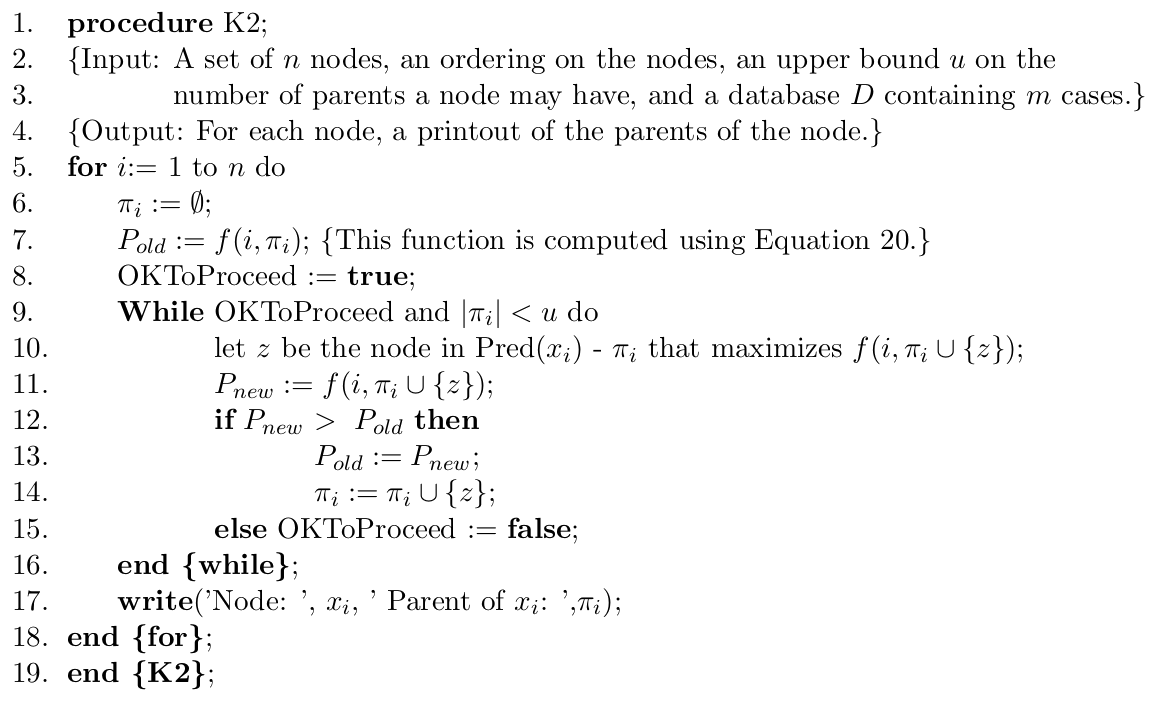

### K2 Original
In the following we report our first implemention of the k2 algorithm

In [ ]:
# Score function f
f <- function(pi, i, D){
    
    V <- unique(D[[i]]) # xi values
    r <- length(V) # number of possible xi values
        
    
    if(length(pi)==0){
        alpha <- numeric(length=r)
    
        for (k in 1:r){
            alpha[k] <- nrow(filter(D,D[[i]]==V[k]))
            }           
    
        
        N <- sum(alpha)
        num <- factorial(r-1)
        den <- factorial(N+r-1)
        alpha.fact <- factorial(alpha)
        alpha.j <- prod(alpha.fact)
        fu <- prod(num*alpha.j/den)

        
        
        
        
    }
    else{
    
    parents.vals <- map(select(D,pi),unique)# A list holding all the unique values
                                            # for each parent
    
    phi <- expand.grid(parents.vals) # possible instantiations of xi parents
                                     # ncol=length(pi)
                                     # nrow= prodotto numero valori di ogni genitori
    q <- nrow(phi) #number of possible instantiations of xi parents

    
    alpha <- matrix(nrow=q,
                    ncol=r)
    
    for (k in 1:r){
        alpha.df <- filter(D,D[[i]]==V[k])
        for (t in 1:q){
            alpha.df1 <- alpha.df
            for (j in 1:length(pi)){
                alpha.df1 <- filter(alpha.df1,alpha.df1[[pi[j]]]==phi[t,j])
            }
            alpha[t,k] <- nrow(alpha.df1)
        }
            
    }

    N <- rowSums(alpha)
    num <- factorial(r-1)
    den <- factorial(N+r-1)
    alpha.fact <- factorial(alpha)
    alpha.j <- apply(alpha.fact,1,prod)
    fu <- prod(num*alpha.j/den)
 
    }
      return (fu) 

}

In [ ]:
# function that performs the k2 algorithm
k2 <- function(vars, u, D){
    fin <- list(length=length(vars))
    for(i in 1:length(vars)){
        curr.node <- vars[i]             #node for which we search the parents for
        par <- c()                       #at the beginning we try with the no-parents case
        p.old <- f(par, curr.node,  D)
        okToProcede <- TRUE              #makes the cycle stop when the requirements are satisfied
        
        prec <- vars[1:i-1]              #nodes which preceed the considered one (parents candidates)
        prec.long <- prec
        
        while(okToProcede & length(par) < u[i] & i!=1 ){
            probs <- map_dbl((prec.long), f, curr.node, D) # from all the possibilities we choose the one with max score
            idx_maxprob <- which.max(probs)
            z <- prec.long[idx_maxprob]
            p.new <- probs[idx_maxprob]
            
            if(p.new > p.old){
                p.old <- p.new
                par <- unlist(z)                          #the next interation parents candidates would have one more dimension
                prec.long <- setdiff(prec,par)            #becaus we attach to the remaining possibilities the best found result
                prec.long <- lapply(prec.long, c, par)
            } else{
                okToProcede <- FALSE
                
                
            }
            
        }
        fin[i] <- list(par)
   
        
    }
    return(fin)
}

The way we implemented the $f$ function has 2 main downsides:
1. the ouput become smaller and smaller as we elnarge the dimension of the dataset used to compute it ($d$). Already for $d>150$ the $f$ function produces ```Nan```. 
2. the computational time is very large

Concerning the first issue it is very complicated to find a subset of the data which is really representative of the whole information we have. This is strengthened by the fact that trying to run the K2 over different subsets of the dataset, the results are very different from each other.

For this reason, and even for the necessity to reduce the computaional time, we tried to change the way to compute the result of the $f$ function, in particular using the ```k2``` score yet implemented in the ```blearn``` library.

In [ ]:
f.net.tot <- model2network("[smoke][gluc][cardio|smoke:gluc]")
f.net.p1 <-  model2network("[smoke]")
f.net.p2 <- model2network("[gluc]")
s.tot <- bnlearn::score(f.net.tot, select(data.cat[1:150,], c("smoke","gluc","cardio")), type="k2")
s.p1 <- bnlearn::score(f.net.p1, select(data.cat[1:150,], c("smoke")), type="k2")
s.p2 <- bnlearn::score(f.net.p2, select(data.cat[1:150,], c("gluc")), type="k2")
cat(sprintf("Result with bnlearn score: %e", exp(s.tot-s.p1-s.p2)), "\n")
cat(sprintf("Result with f function: %e", f(c("smoke", "gluc"), "cardio" , data.cat[1:150,])))

Result with bnlearn score: 1.486662e-47Result with f function: 1.486662e-47

As we can see, the ```bnlearn``` score is equal to the logarithm of the product between the results of $f$ for: 
- the candidate parents connected to the considered node and
- each parent node considered individually

### K2 New

Given the fact that the ```bnlearn::score( )``` function takes as input a bnlearn dag we implemented a function which returns a dag given the current node inspected by the K2 algorithm and a set of parents:

In [ ]:
big.net <- function(par, curr) {
    tus_dag <- empty.graph(nodes = c(curr,par))
    if(length(par)!=0){
        for(j in par){
            tus_dag <- set.arc(tus_dag, to = curr, from = as.character(j))
        }
    }
    return(tus_dag)
}

In [ ]:
k2.new <- function(vars, u, D, type='k2'){
    fin <- list(length=length(vars))
    for(i in 1:length(vars)){
        curr.node <- vars[i]
        par <- c()
        netstr <- empty.graph(nodes = curr.node)
        p.old <- bnlearn::score(netstr, select(D,curr.node), type=type)
        okToProcede <- TRUE
        
        prec <- vars[1:i-1]
        prec.long <- prec
        
        while(okToProcede & length(par) < u[i] & i!=1 ){
            probs<- c()
            for (p in 1:length(prec.long)) {
                curr.net <- big.net(prec.long[[p]], curr.node)
                sc <- bnlearn::score(curr.net, select(D,c(curr.node,prec.long[[p]])), type=type)

                for (k in 1:length(prec.long[[p]])) {
                    par.net <- big.net(c(),prec.long[[p]][[k]])
                    sc <- sc-bnlearn::score(par.net, select(D,prec.long[[p]][[k]]), type=type)
                }
                probs<-c(probs,sc)
            }
            
            idx_maxprob <- which.max(probs)
            z <- prec.long[idx_maxprob]
            p.new <- probs[idx_maxprob]
            
            if(p.new > p.old){
                p.old <- p.new
                par <- unlist(z)
                prec.long <- setdiff(prec,par)
                prec.long <- lapply(prec.long, c, par)
            } else{
                okToProcede <- FALSE
            }
        }
        fin[i] <- list(par)
    }
    return(fin)
}

### From the K2 result to BN structure
The implemented K2 algorithms return a list whose each entry corresponds to a node of the net and contains a vector of its parents. The following ***k2_to_net( )* function** converts the list returned by the k2 into a ```dag```

In [ ]:
#converts the list of parents of each node given as output by K2 in a BN
k2_to_net <- function(var_list, k2_res, show=TRUE){
    tus_dag <- empty.graph(nodes = var_list)
    for(i in 1:length(var_list) ){
        if(length(k2_res[i])!=0){
            for(j in k2_res[[i]]){
                tus_dag <- set.arc(tus_dag, to = var_list[i], from = as.character(j))
            }
        }
        
    }
    if (show) {
        options(repr.plot.width=16, repr.plot.height=10)
        pp <- graphviz.plot(tus_dag,render=FALSE)
        nodeRenderInfo(pp) = list(col= 'black',
                                  textCol = 'white',
                                  fill = c('age_year'='#BF616A',
                                    'height'='#BF616A',
                                    'weight'='#BF616A',
                                    'gender'='#BF616A',
                                    'ap_hi'='#A3BE8C',
                                    'ap_lo'='#A3BE8C',
                                    'cholesterol'='#A3BE8C',
                                    'gluc'='#A3BE8C',
                                    'smoke'='#B48EAD',
                                    'alco'='#B48EAD',
                                    'active'='#B48EAD',
                                    'cardio'='#EBCB8B'),
                                  fontsize= 40)
        renderGraph(pp)
    }
    return(tus_dag)
}

### Features ordering => Block permutations
The K2 method for BN learning is an order dependent algorithm: this means that it reaches different network structures if the input nodes ordering are permuted. Given this fact we have 2 possibilities:
1. Try to infer the best node ordering based on our knowledge
2. Go for a brute-force approach and try all the possible permutations of the nodes ordering

### 1) Network Estimation with fixed input variables
here we show the result we get from the K2 algorithm in the case of fixed ordering for the input varibles

K2 score of the network: -555269.3583

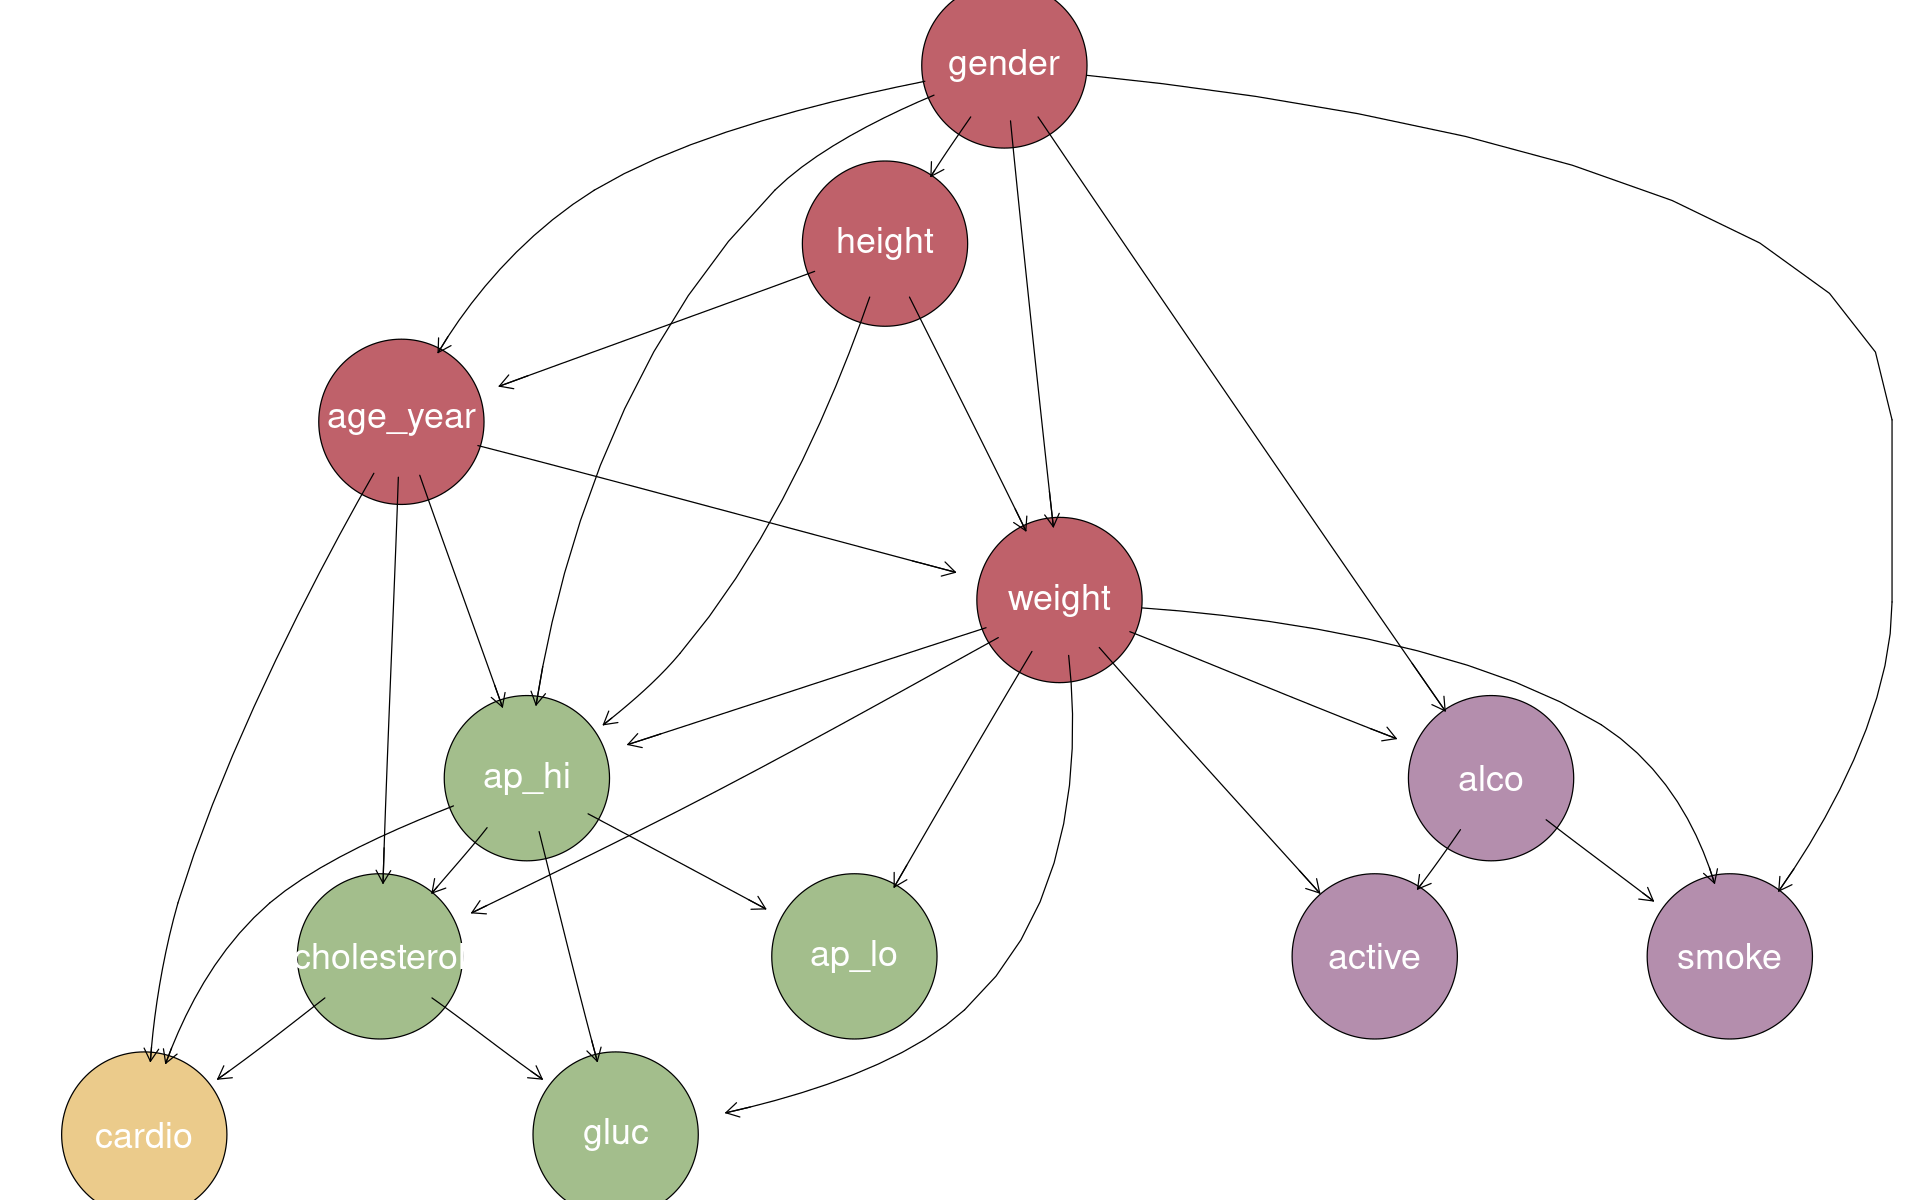

In [ ]:
var_list <- c("gender","height",  "age_year", "weight","alco", "active",   "smoke", "ap_hi", "ap_lo", "cholesterol", "gluc", "cardio")
upper_bounds <- 0:11
k2_res <- k2.new(var_list, upper_bounds, data.cat)
net <- k2_to_net(var_list, k2_res)
cat(sprintf("K2 score of the network: %.4f",bnlearn::score(net, data.cat, type='k2')))

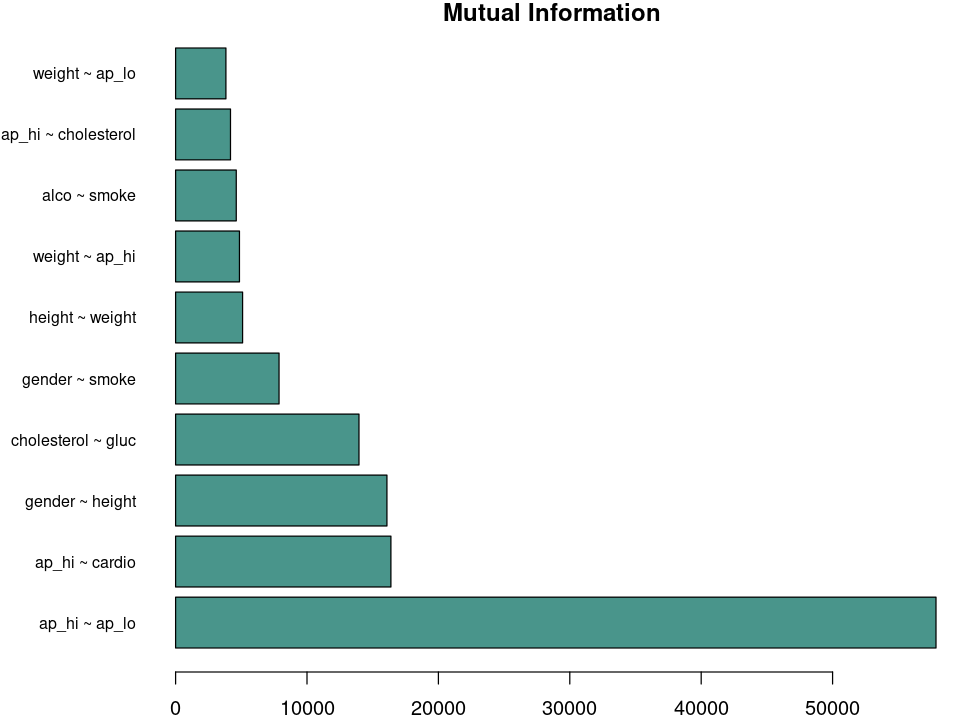

In [ ]:
test<-indipendence.test(net,data.cat,graph=TRUE)

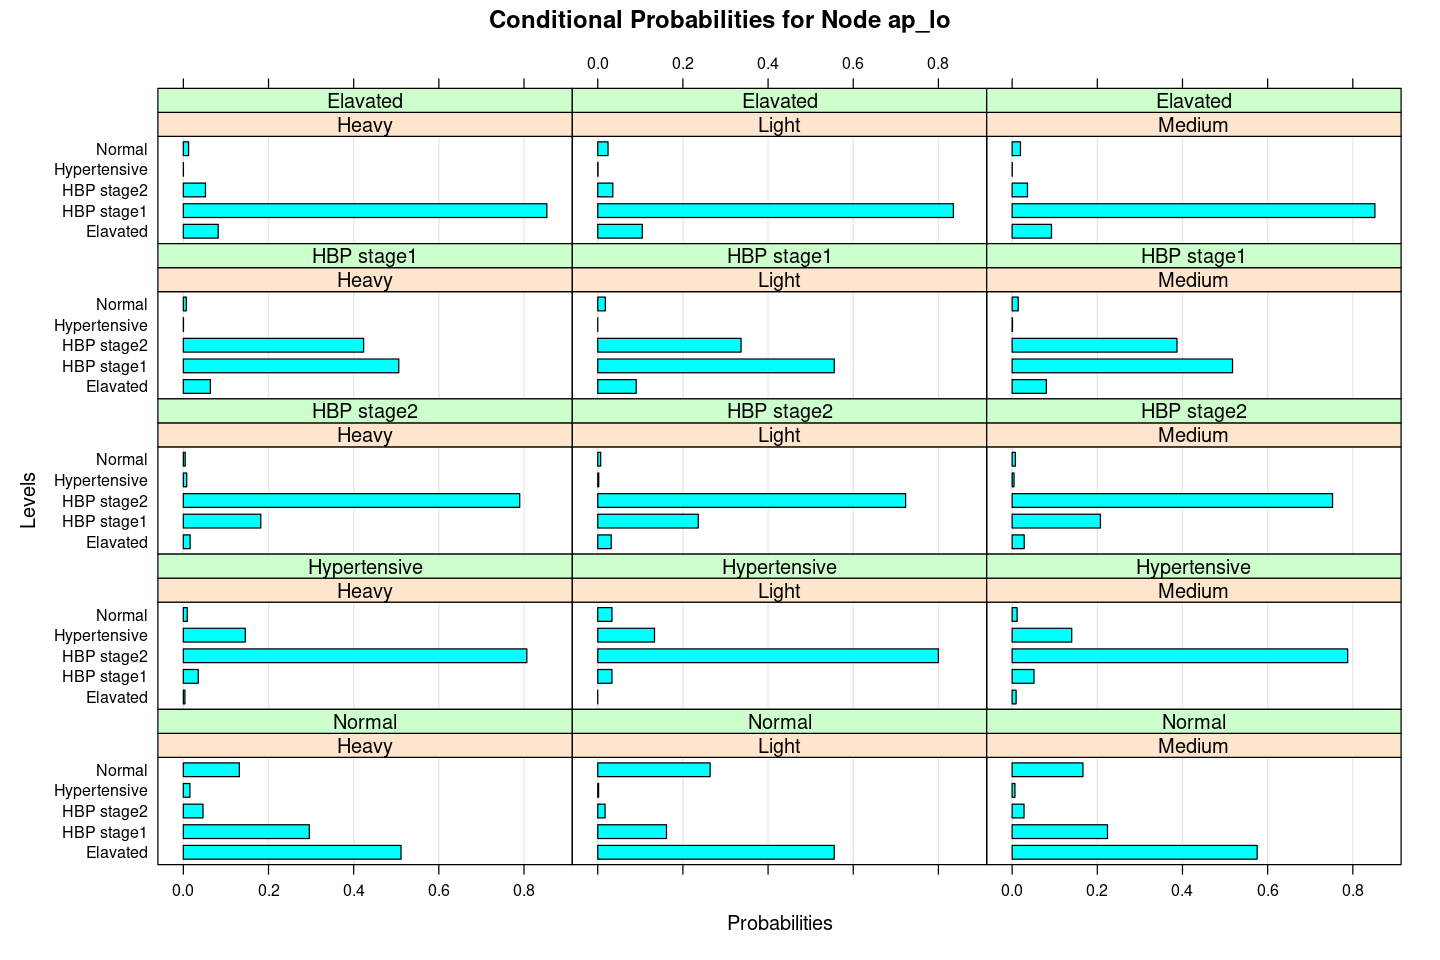

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)
fit_net <- bn.fit(net,data.cat,method='mle')
bn.fit.barchart(fit_net$ap_lo)

### 2) Best Network Estimation
Concerning the brute force approach it's clear that is higly inefficient and we soon get into scalability issues: the possible permutations of a group of $n$ distinct elements are $P_n=n!$ and in our case,given the fact that we are dealing with a 12 variables, the number of possible permutations is $P_{12}=12!=479001600$.\
In order to deal with this problem we try an hybrid approach: we divide the dataset variables in 5 blocks which we keep in the following fixed order:
- First Block: gender, age_year, height
- Second Block: weight
- Third Block: smoke, alco, active
- Fourth Block: ap_hi, ap_lo, gluc, cholesterol
- Fifth Block: cardio

Then we compute all the possible permutations within each block getting as a result a much smaller number of different input for the K2 algortihm: indeed in this way we get $3!\cdot 3! \cdot 1 \cdot 4!= 864$ input possibilities in spite of the previous $479001600$.\
In the following code is implemented the division in blocks and then all the possible block's permutation are computed. 

In [ ]:
ord_list <- matrix(ncol=12, nrow=6*6*24)

first_level <- c("gender", "age_year", "height")
third_level <- "weight"
second_level <- c("smoke", "alco", "active" )
fourth_level <- c("ap_lo", "ap_hi", "gluc", "cholesterol")
fifth_level <- "cardio"


first_perm <- permutations(length(first_level), length(first_level), first_level )
second_perm <-permutations(length(second_level), length(second_level), second_level )
fourth_perm <-permutations(length(fourth_level), length(fourth_level), fourth_level )

In [ ]:
count <- 1


for (i in 1:nrow(first_perm)) {
  v0 <- first_perm[i,]
  for(j in 1:nrow(second_perm)){
      v1<- c(third_level, second_perm[j,])
      for(k in 1:nrow(fourth_perm)){
          v2<- c(fourth_perm[k,] , fifth_level) 
          ord_list[count, ] <- c(v0, v1, v2)
          count <- count + 1
          v2 <- c()   
      }
      v1 <- c() 
  }
}

In [ ]:
get_score <- function(var_list, D, k2.score='k2', score.type='k2'){
    upper_bounds <- c(0:12)
    set.seed(123)
    k2_res <- k2.new(var_list, upper_bounds, D, type=k2.score) 
    net <- k2_to_net(var_list, k2_res, show=FALSE)
    net_score <-bnlearn::score(net, D, type=score.type)    
    return(list(k2_res, net_score))
}

Here we show the best network we get usign the k2 algorithm and exploiting block permutations

#### Discrete case

In [ ]:
ord_vars <- split(t(ord_list), rep(1:nrow(ord_list), each = ncol(ord_list)))
score_list <- map(ord_vars,get_score, data.cat)
max_score_idx <-sapply(score_list, "[[", 2) %>% unlist() %>% which.max() %>% unname()
best_seq <- ord_list[max_score_idx,]
best_seq

[1] "age_year"    "height"      "gender"      "weight"      "smoke"      
 [6] "active"      "alco"        "ap_hi"       "ap_lo"       "cholesterol"
[11] "gluc"        "cardio"

K2 score of the network: -555230.3663

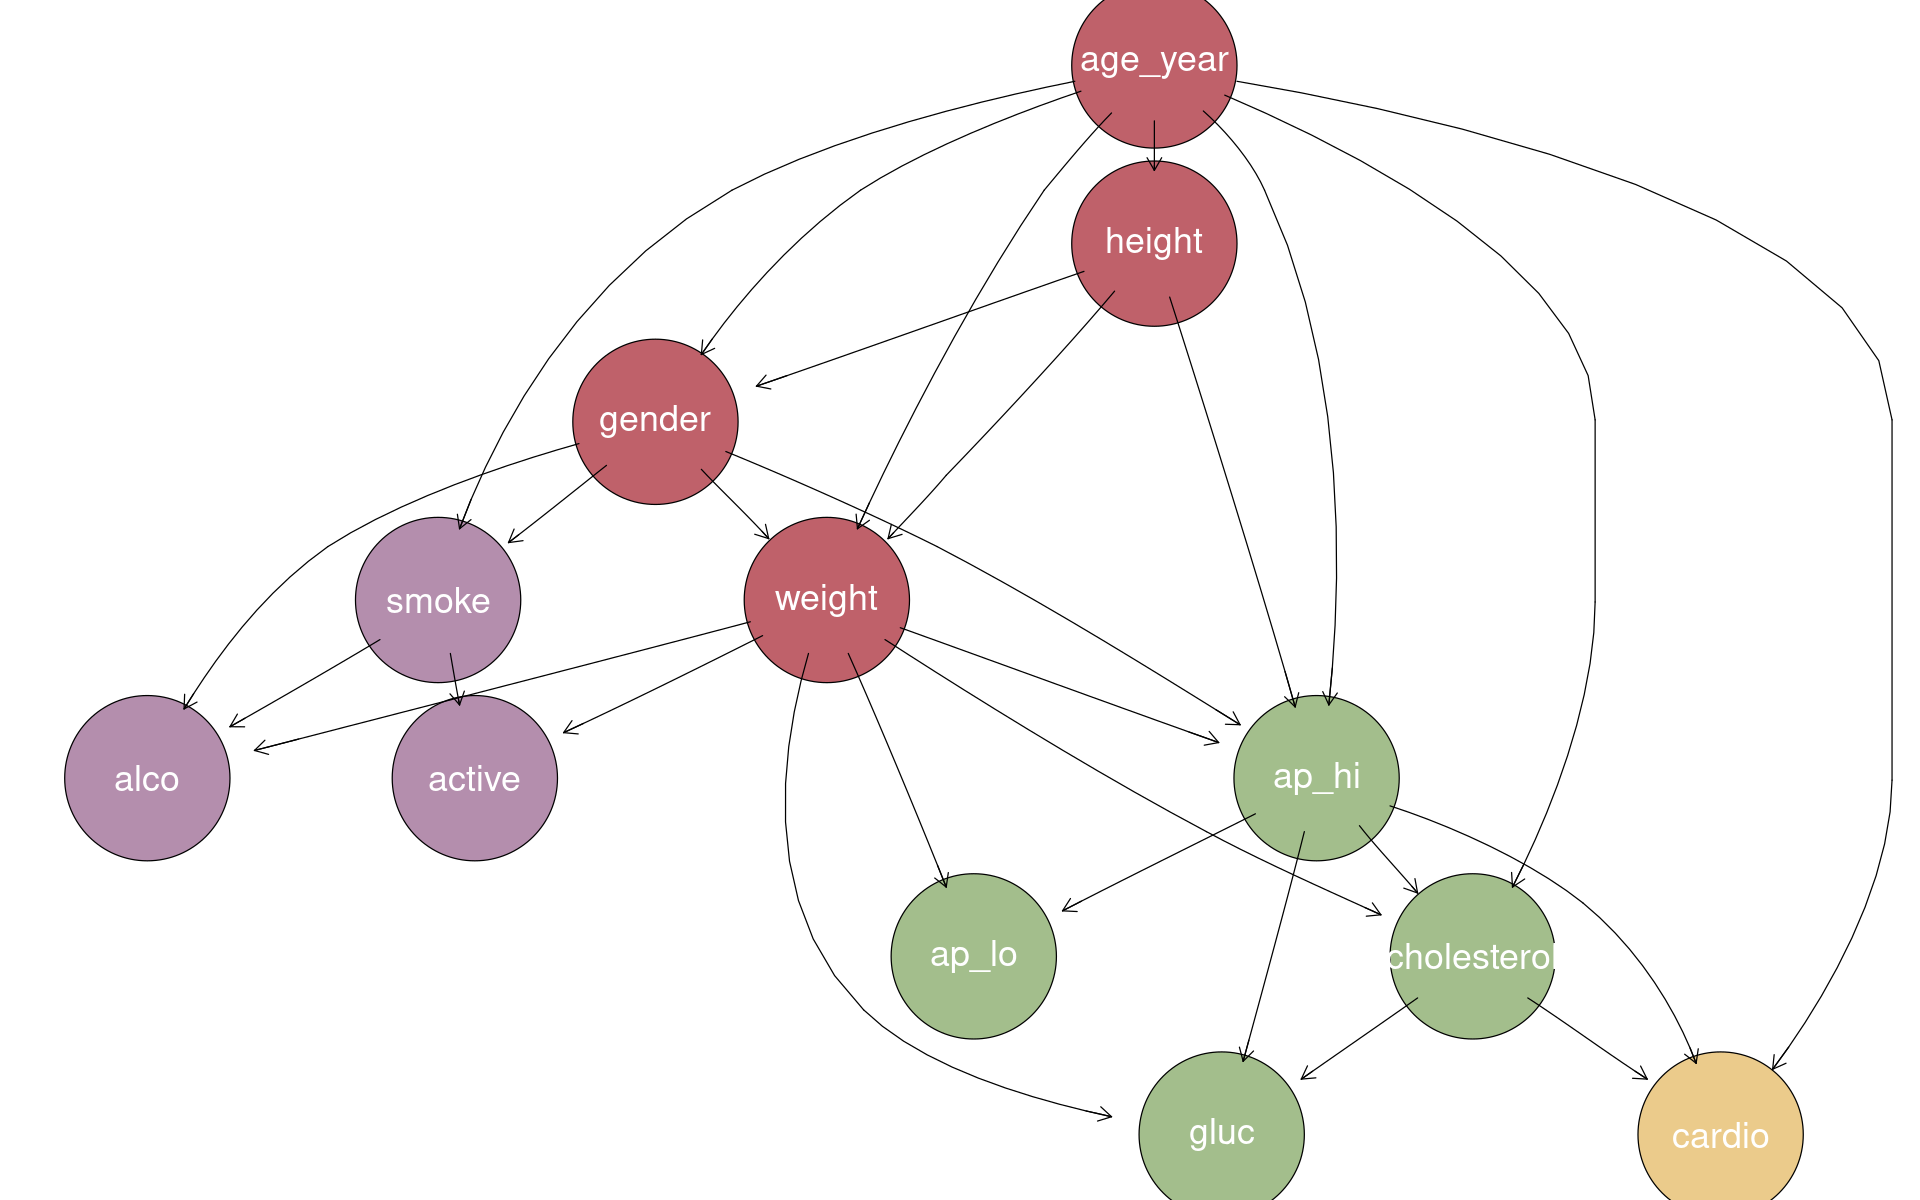

In [ ]:
best_net <- k2_to_net(best_seq, score_list[[max_score_idx]][[1]])
cat(sprintf("K2 score of the network: %.4f",score_list[[max_score_idx]][[2]]))

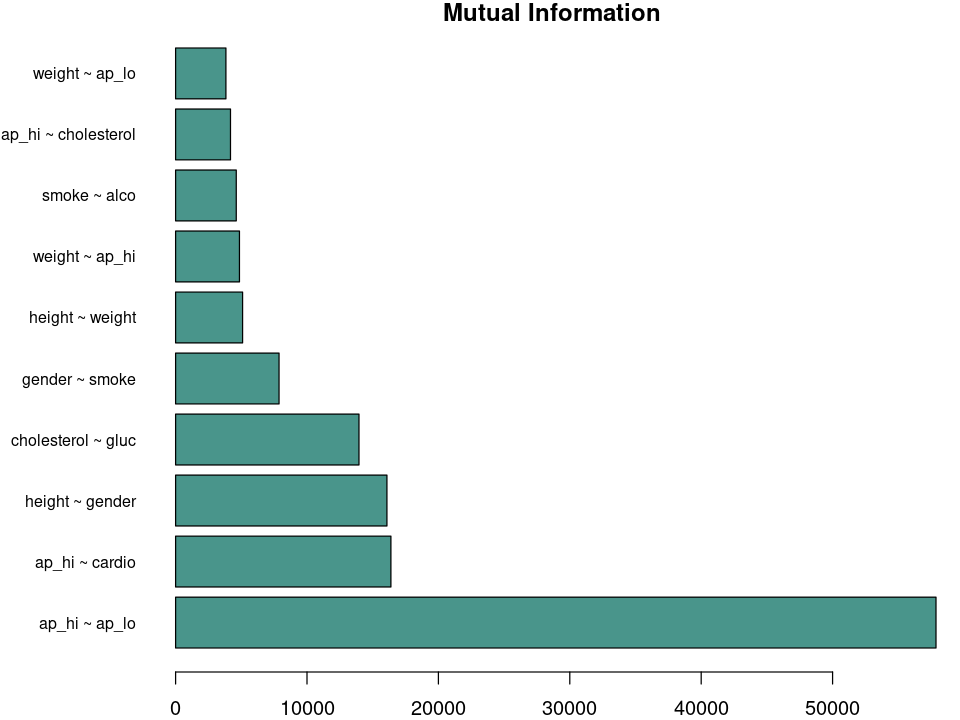

In [ ]:
test.cat <- indipendence.test(best_net,data.cat,graph=TRUE)

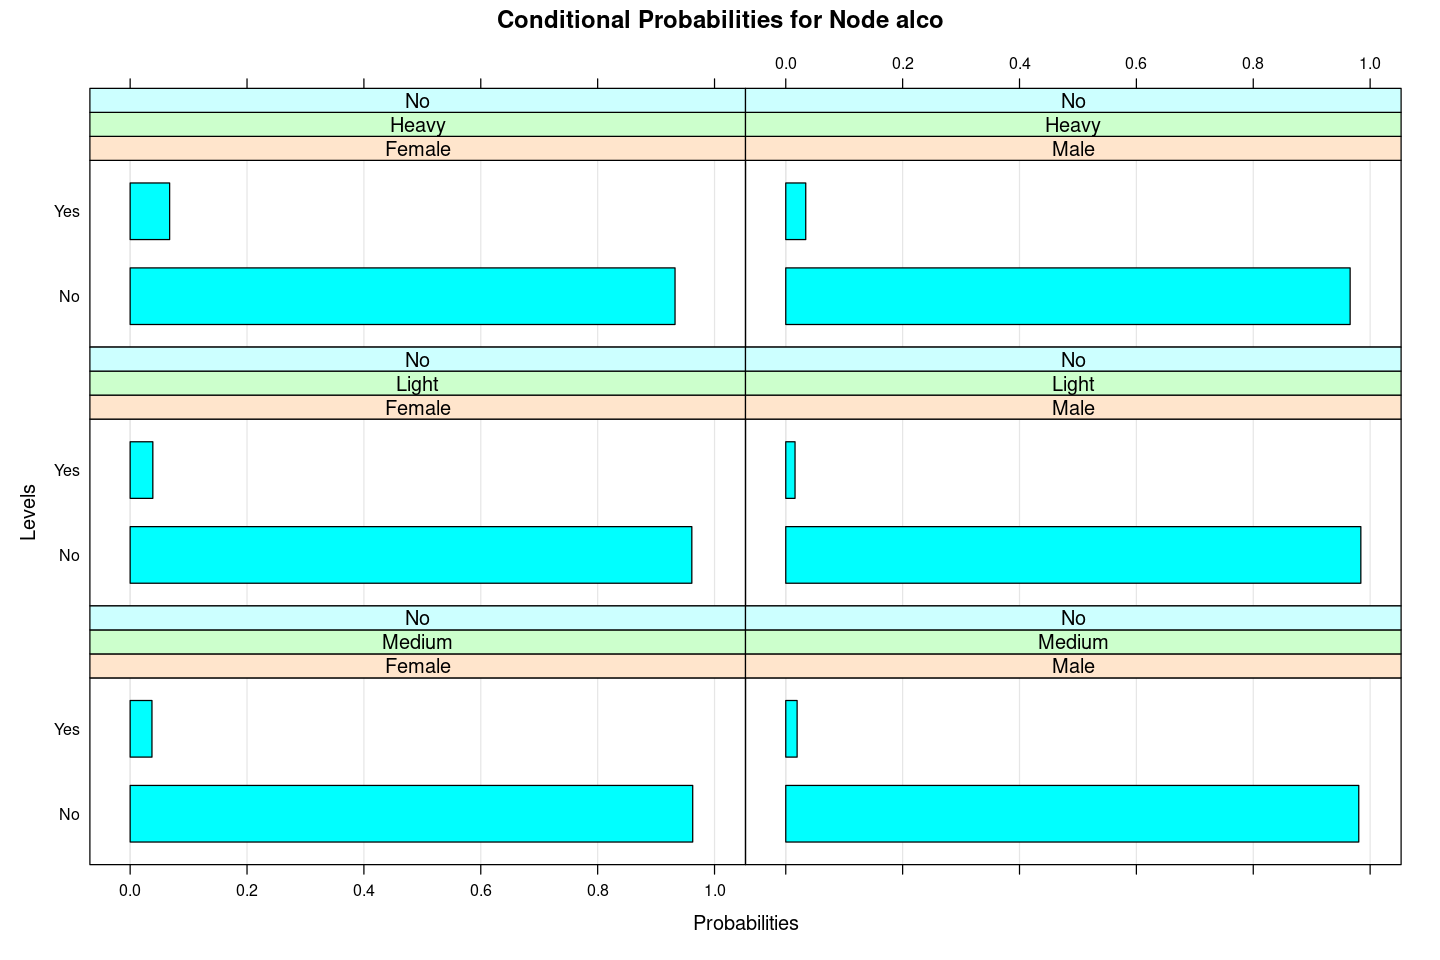

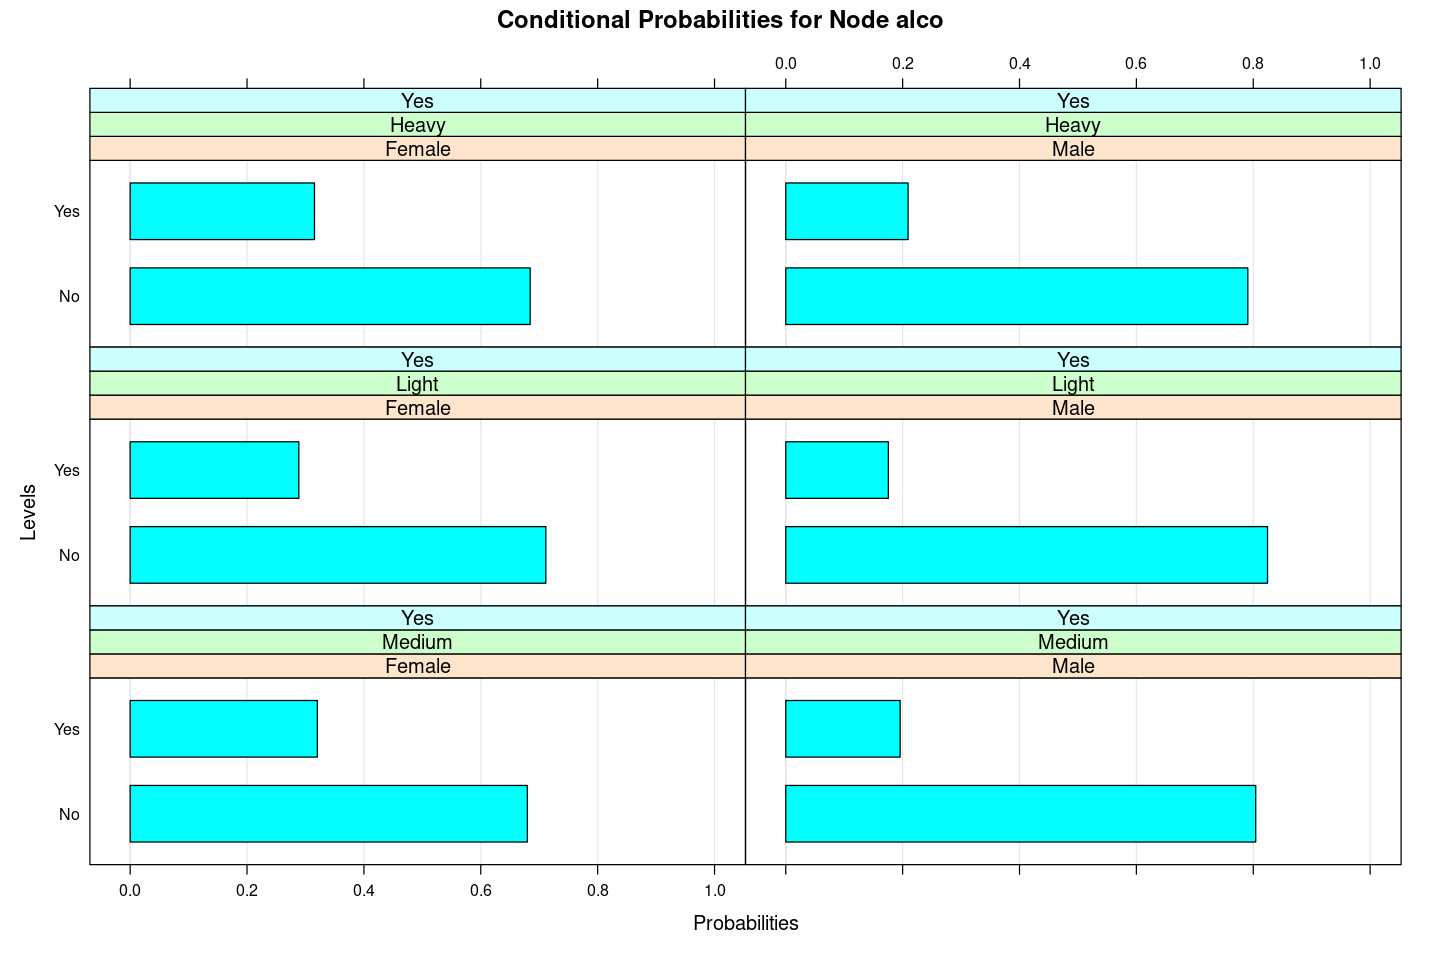

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)
fit_net_cat <- bn.fit(best_net,data.cat,method='mle')
bn.fit.barchart(fit_net_cat$alco)

#### Continuous case
With the nodes order we just found we can now build another DAG using the continuous dataset, in which all the feature values are interpreted as continuous numeric quantities.

The score we use into the K2 algorithm and to evaluate the final network is the $\textit{BGe}$, which stands for Bayesian metric for Gaussian networks. It's a score used for continuous datasets and it supposes that the varibales are distributed in a gaussian fashion, assumption that is respected by most of our dataset (some categorical features don't display such a behaviour in a very strong way).

K2 score of the network: -1530029.1466

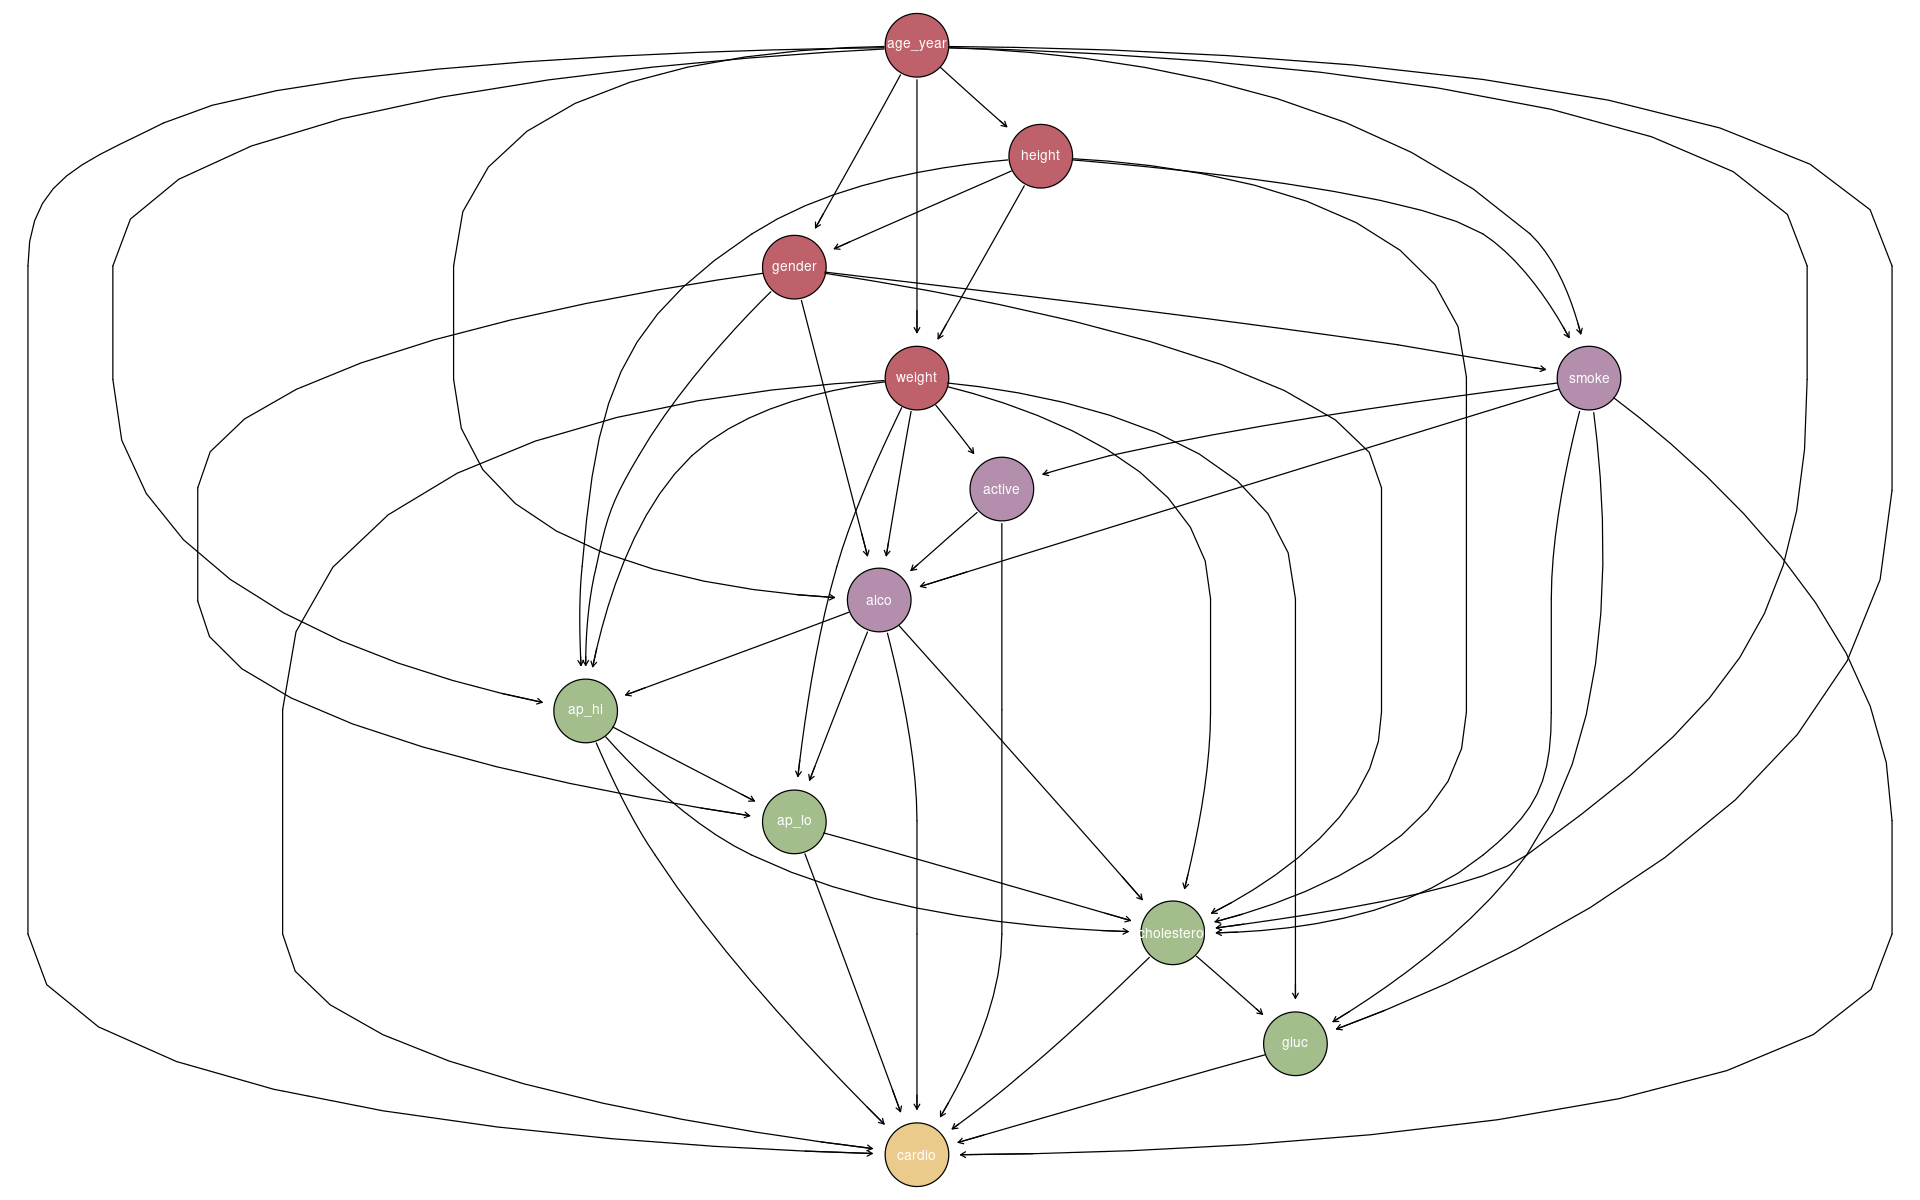

In [ ]:
best_res_cont <- k2.new(best_seq, 0:12, data.train, 'bge' )
best_net_cont <- k2_to_net(best_seq, best_res_cont)
cat(sprintf("K2 score of the network: %.4f",bnlearn::score(best_net_cont, data.train, 'bge')))

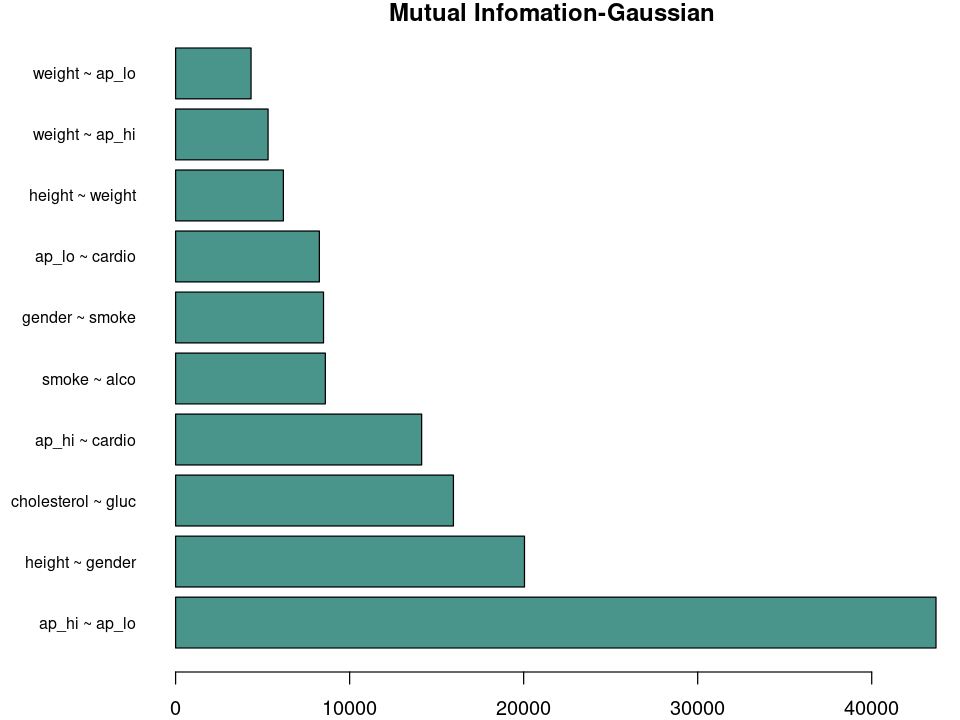

In [ ]:
test.cont <- indipendence.test(best_net_cont,data.train,type='continuous',graph=TRUE)

## Bayesian Networks for Classifications tasks
In order to evaluate the capability of the BNs we built we also test their classification power: in order to do this we use the function ```predict```  of ```bnlearn```. There are two methods that can be followed:
- ```parents```: it utilizes the frequentist approach in which the predicted values are computed by plugging in the new values for the parents of node in the local probability distribution of node extracted from fitted.
- ```bayes-lw```: the predicted values are computed by averaging likelihood weighting simulations performed using all the available nodes as evidence (obviously, with the exception of the node whose values we are predicting). The number of random samples which are averaged for each new observation is controlled by the n optional argument; the default is 500. If the variable being predicted is discrete, the predicted level is that with the highest conditional probability.


In the following piece of code it is implemented a function (`score.pred( )`) that, given a DAG and a dataset, splits the data into a training set ($\frac{2}{3}$ of the total) and test set ($\frac{1}{3}$ of the total), fits the network over the training set and computes the classification accuracy over the test set.

In [ ]:
prob.coll <- function(x) {
    if (x<0.5) {
        return("0")
    }
    else {
        return("1")
    }
}


score.pred <- function(net, D, pred.node="cardio", fit.type='mle', pre.method='parents', iss.my=10, cat=TRUE, title="") {
  
  set.seed(101)
  ntrain <- ceiling(nrow(D)*2/3)
  ntest <- nrow(D)-ntrain
  train <- sample(1:nrow(D), ntrain)
  if (fit.type=='mle'){
    bn.cat <- bn.fit(net, D[train,], method=fit.type)
  } else if (fit.type=='bayes') {
    bn.cat <- bn.fit(net, D[train,], method=fit.type, iss=iss.my)
  } else {
    return("Error")
  }
  
  mp.par <- predict(bn.cat,data = D[-train,], node=pred.node, method=pre.method)
    
  if (!cat) {
    mp.par <- map_chr(mp.par,prob.coll) %>% as.factor()
  }

  cat("----------------------------------------\n")
  cat(paste("Network: ", title), "\n")
  cat("----------------------------------------\n")
  cat(paste("\nFitting method: ", fit.type, "\n"))
  cat(paste("Predicting method: ", pre.method, "\n\n"))
  cm <- caret::confusionMatrix(mp.par, D[-train,][[pred.node]] %>% as.factor())
  acc <- cm$overall[['Accuracy']]
  cat("\nConfusion Matrix:\n")
  print(cm$table)
  cat(sprintf("\nPrediction accuracy: %.4f", acc), "\n\n\n")  
  
}

In [ ]:
#computing the classification accuracies
score.pred(tus_dag, data.cat, title="Self-made Network")
score.pred(tus_dag, data.cat, title="Self-made Network", fit.type='bayes', pre.method = 'bayes-lw')
score.pred(net, data.cat, title="Self-ordered Network")
score.pred(net, data.cat, title="Self-ordered Network", fit.type='bayes', pre.method = 'bayes-lw')
score.pred(best_net, data.cat, title="Best Network (categorical)")
score.pred(best_net, data.cat, title="Best Network (categorical)", fit.type='bayes', pre.method = 'bayes-lw')
score.pred(best_net_cont, data.train, cat=FALSE, title="Best Network (continous)")

----------------------------------------
Network:  Self-made Network 
----------------------------------------

Fitting method:  mle 
Predicting method:  parents 


Confusion Matrix:
          Reference
Prediction   No  Yes
       No  9267 3868
       Yes 2496 7692

Prediction accuracy: 0.7271 


----------------------------------------
Network:  Self-made Network 
----------------------------------------

Fitting method:  bayes 
Predicting method:  bayes-lw 


Confusion Matrix:
          Reference
Prediction   No  Yes
       No  9439 4071
       Yes 2327 7496

Prediction accuracy: 0.7258 


----------------------------------------
Network:  Self-ordered Network 
----------------------------------------

Fitting method:  mle 
Predicting method:  parents 


Confusion Matrix:
          Reference
Prediction   No  Yes
       No  8695 3221
       Yes 3071 8346

Prediction accuracy: 0.7303 


----------------------------------------
Network:  Self-ordered Network 
---------------------------

|| Score |Accuracy (mle) | Accuracy (Bayes)|
| :- | -: | :-: |:-:|
|  Self-made BN | -605573 [k2]| 0.7271 | 0.7258
| Self-ordered BN | -555269 [k2]| 0.7303| 0.7291
| Best net CAT| -555230 [k2]| 0.7303| 0.7291
| Best net CONT| -1530029 [bge] | 0.7294| \

As we can see the prediciton accuracies of Self-ordered BN and Best net CAT are equal, as their confusion matrices, altough their structures and the K2 scores are different. Probably we are in the case of equivalent networks. Two network structures are said to be equivalent if the set of distributions that can be represented with one of those structures is identical to the set of distributions that can be represented with the other. In fact the score K2 is not score equivalent.

We can check this hypotesis by computing the scores of the two networks using different method, which are score equivalent:

|| Self-ordered BN | Best net CAT |
| :- | -: | :-: |
|  aic |-553123 |-53099|  
| loglik | -553976 | -553951
| bic| -557858 | -557851

The scores are not equal in the 2 cases, so we can conclude that they are not equivalent.

As mentioned in  *F. Cooper,  A Bayesian Method for the Induction of Probabilistic Networks from Data*, another class of algorithms that aims to make this type of classifications predictions is Decision Tree. In the following section Classification Tree and Random Forest methods are discussed and applied to our datasets with the purpose of finding a model that maximizes expected classification accuracy on new cases. The performances are compaared with the ones of Bayesian Network.

## Classification Tree
 A Decision Tree is a predictive model capable to perform multi-class classification on a dataset by applying cuts on the features and splitting the data in each node in two branches based on these cuts. Each node of the tree represents a cut on a feature and the final nodes (the leaves) assign to each sample its label. A node becomes a leaf when all the data that it contains belong to a single class or when the a priori fixed maximum depth of the tree is reached.
 
 
 The choice of the feature to be splitted is made by looking at the Gini coefficient defined as $G(i)=1-\sum_{j=1}^m f(i,j)^2$ where $f(i,j)$ is the frequency of the class $j$ when we restrict the data to the $i$-th cathegory. It's chosen the feature $i$ and a corrisponding cut that has minimum Gini coefficient. When $G(i)=0$ the node contains samples that belong to a single class and it becomes a leaf. If we reach the maximum depth but $G(i)\neq 0$ it is assigned the label of the most frequent class in the node. 

In [ ]:
options(repr.plot.width=10, repr.plot.height=8)

First of all, the datasets are divided into a training set composed by $\frac{2}{3}$ of the total sample with which the model is built and a test composed by $\frac{1}{3}$ of the total sample used to test the performances of the model.

In [ ]:
set.seed(101)

ntrain <- ceiling(nrow(data.train)*2/3)
ntest <- nrow(data.train)-ntrain

cat("N train: ", ntrain, "\t N test: ", ntest, "\n")
train <- sample(1:nrow(data.train), ntrain) %>% matrix(., nrow=length(.), ncol=1)

training.cat <- data.cat[ train,]
testing.cat <- data.cat[-train,]

training.cont <- data.train[ train,]
testing.cont <- data.train[-train,]

N train:  46667 	 N test:  23333 


The function `build.cardiotree` is used to build a tree model of maximum depth equal to the input parameter `maxdepth`. The model is trained using traning data and it is used to make predictions over the test set. The accuracy of the predictions and other informations about the model can be computed. 


When daeling with continous dataset the output of the `predict` function is the probability between 0 and 1 of that sample to be linked to the presence of cardiovascular desease. In order to be compared to the labels contained in our dataset, this output is converted into binary by the function `tree.assign`.

In [ ]:
tree.assign<- function(x, thresh=0.5) {
  if (x<thresh){
    x<-0.L
  } else {
    x<-1.L
  }
}



build.cardiotree <- function(maxdepth, cat=TRUE , plot=FALSE, info=FALSE, testacc=TRUE){
    
    ctrl = rpart.control(maxdepth=maxdepth, cp=0)
    
    if(cat){    
        
        test <- testing.cat$cardio
        tree.cardio <- rpart(cardio ~ ., data = data.cat, sub=train, method='class', control=ctrl)
        pred <- predict(tree.cardio, testing.cat, type="class")
        acc <- caret::confusionMatrix(pred, testing.cat$cardio)$overall[['Accuracy']]
        
    }else{
        test <- as.factor(testing.cont$cardio)
        tree.cardio <- rpart(cardio ~ ., data = data.train, sub=train, control=ctrl)
        pred <- predict(tree.cardio, testing.cont)
        pred <- map_chr(pred, tree.assign, thresh=0.5) %>% unname() %>% as.factor()
        acc <- caret::confusionMatrix(pred, test)$overall[['Accuracy']]        
    }
    

    
    if(plot){
        fancyRpartPlot(tree.cardio)        
    }
    if(info){
        df.cardio <- tree.cardio$frame
        cat("Number of nodes: ", nrow(df.cardio), "\n")
        cat("Number of leaves: ", filter(df.cardio, var=="<leaf>") %>% nrow(),"\n")
        cat("\nConfusion Matrix")
        print(table(pred, test))
        cat("\nAccuracy: ", caret::confusionMatrix(pred, test)$overall[['Accuracy']], "\n")
    }

    if(testacc){
        return(acc)
    }else{
        return(tree.cardio)
    }
}

#### Categorical dataset
Here is reported an example of decision tree with depth $=4$.

Number of nodes:  13 
Number of leaves:  7 

Confusion Matrix     test
pred    No  Yes
  No  8536 3098
  Yes 3230 8469

Accuracy:  0.7287961 


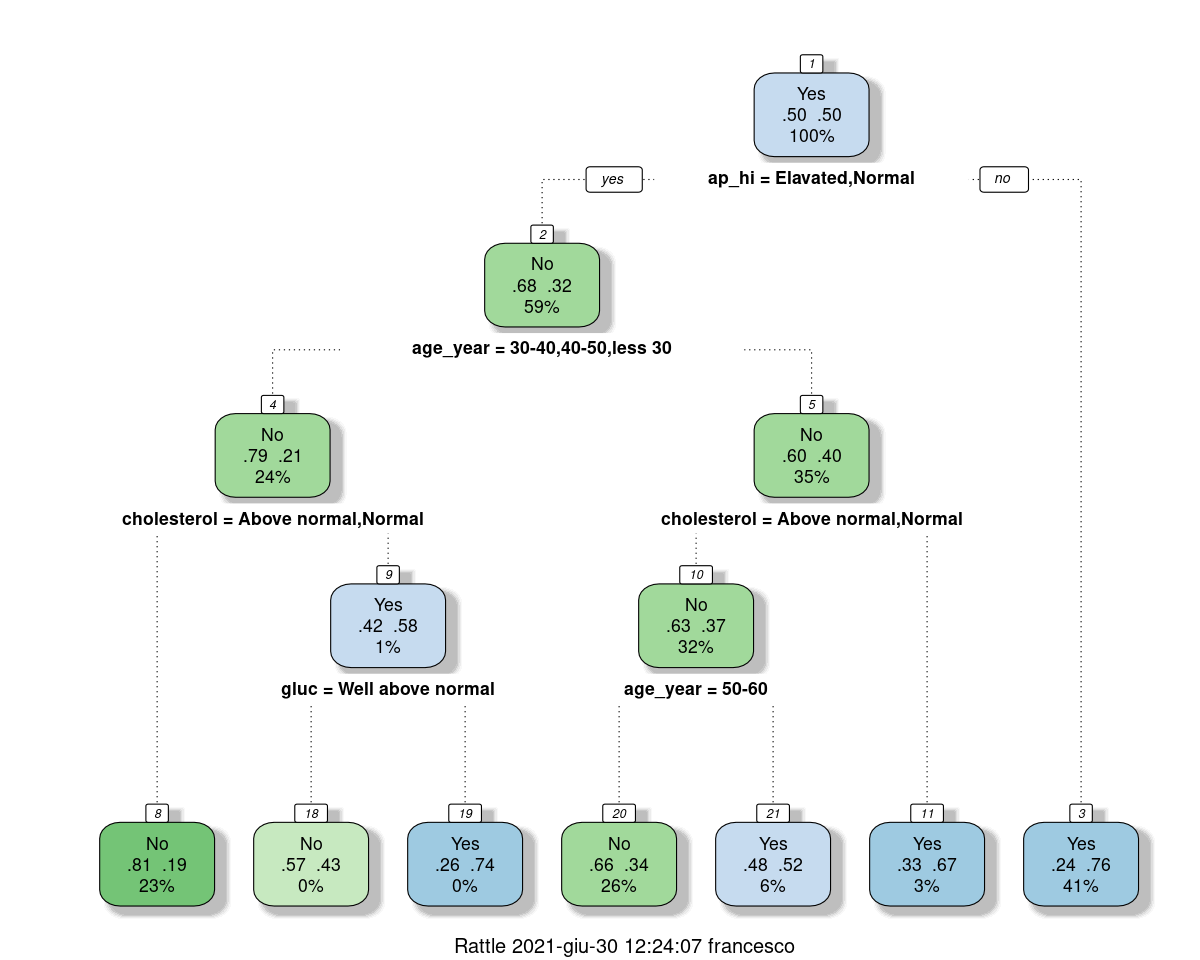

In [ ]:
tree.example <- build.cardiotree(4, cat=TRUE, plot=TRUE, info=TRUE, testacc=FALSE)

Varying the maximum tree depth in a range from 1 to 30, it is found the value of depth parameter that leads to the best accuracy.

In [ ]:
result <- map(1:30, build.cardiotree)
best.depth <- result %>% unlist() %>% which.max() 
max.acc <- result[best.depth] %>% unlist()
cat("Best accuracy: ", max.acc, "\nDepth: " , best.depth, "\n")

Best accuracy:  0.7325248 
Depth:  11 


Number of nodes:  419 
Number of leaves:  210 

Confusion Matrix     test
pred    No  Yes
  No  9113 3588
  Yes 2653 7979

Accuracy:  0.7325248 


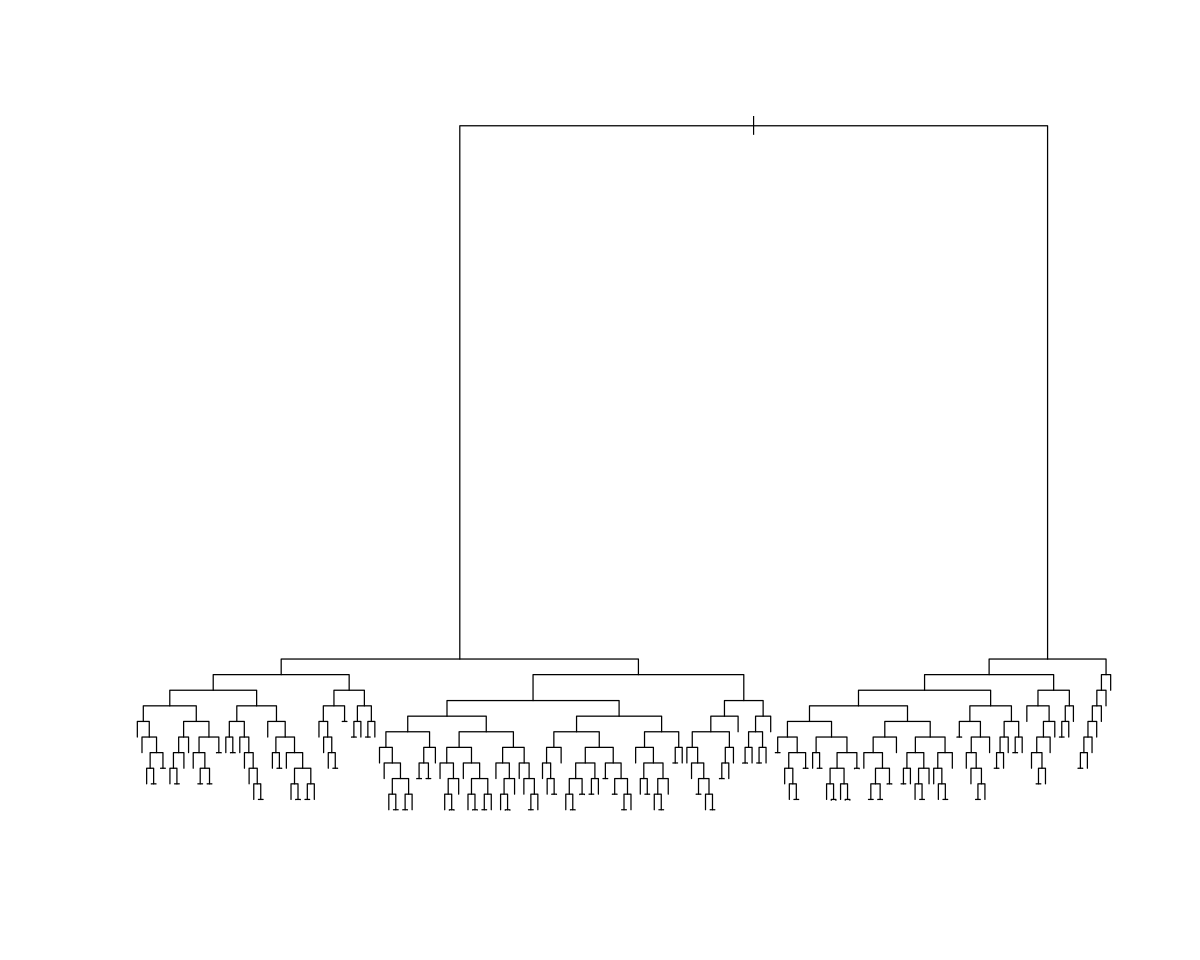

In [ ]:
best.tree <- build.cardiotree(best.depth, cat=TRUE, plot=FALSE,info=TRUE, testacc=FALSE)
plot(best.tree)

In the table below it can be observed which are the features that matter the most in the costruction of the Decision Tree.

In [ ]:
imp.df <- best.tree$variable.importance %>% data.frame() 
colnames(imp.df) <- "importance" 
imp.df

,importance
,<dbl>
ap_hi,5054.32925
ap_lo,2891.87629
cholesterol,1085.78619
age_year,918.00525
weight,643.94400
gluc,304.49159
active,67.54151
gender,42.17557
height,41.04744


### Continous Dataset

Here is reported an example of decision tree with depth $=3$.

Number of nodes:  15 
Number of leaves:  8 

Confusion Matrix    test
pred    0    1
   0 9131 3734
   1 2635 7833

Accuracy:  0.727039 


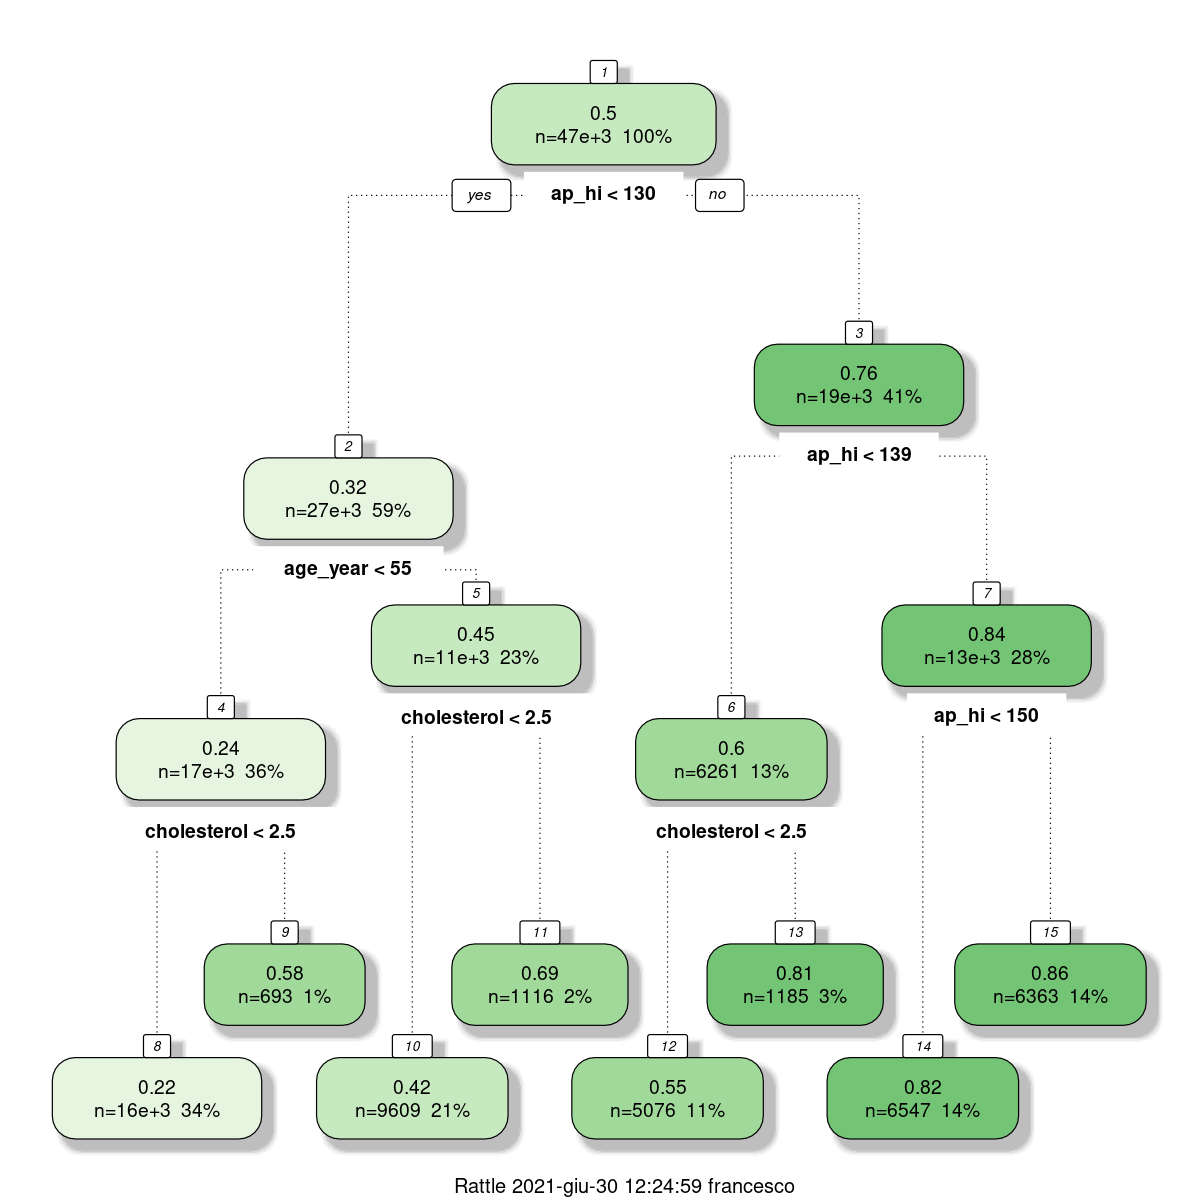

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
tree.example.cont <- build.cardiotree(3, cat=FALSE, plot=TRUE, info=TRUE, testacc=FALSE)

Varying the maximum tree depth in a range from 1 to 30, it is found the value of depth parameter that leads to the best accuracy.

In [ ]:
result.cont <- map(1:30, build.cardiotree, cat=FALSE)
best.depth.cont <- result.cont %>% unlist() %>% which.max() 
max.acc.cont <- result.cont[best.depth.cont] %>% unlist()
cat("Best accuracy: ", max.acc.cont, "\nDepth: " , best.depth.cont, "\n")

Best accuracy:  0.7311962 
Depth:  5 


Number of nodes:  63 
Number of leaves:  32 

Confusion Matrix    test
pred    0    1
   0 9734 4240
   1 2032 7327

Accuracy:  0.7311962 


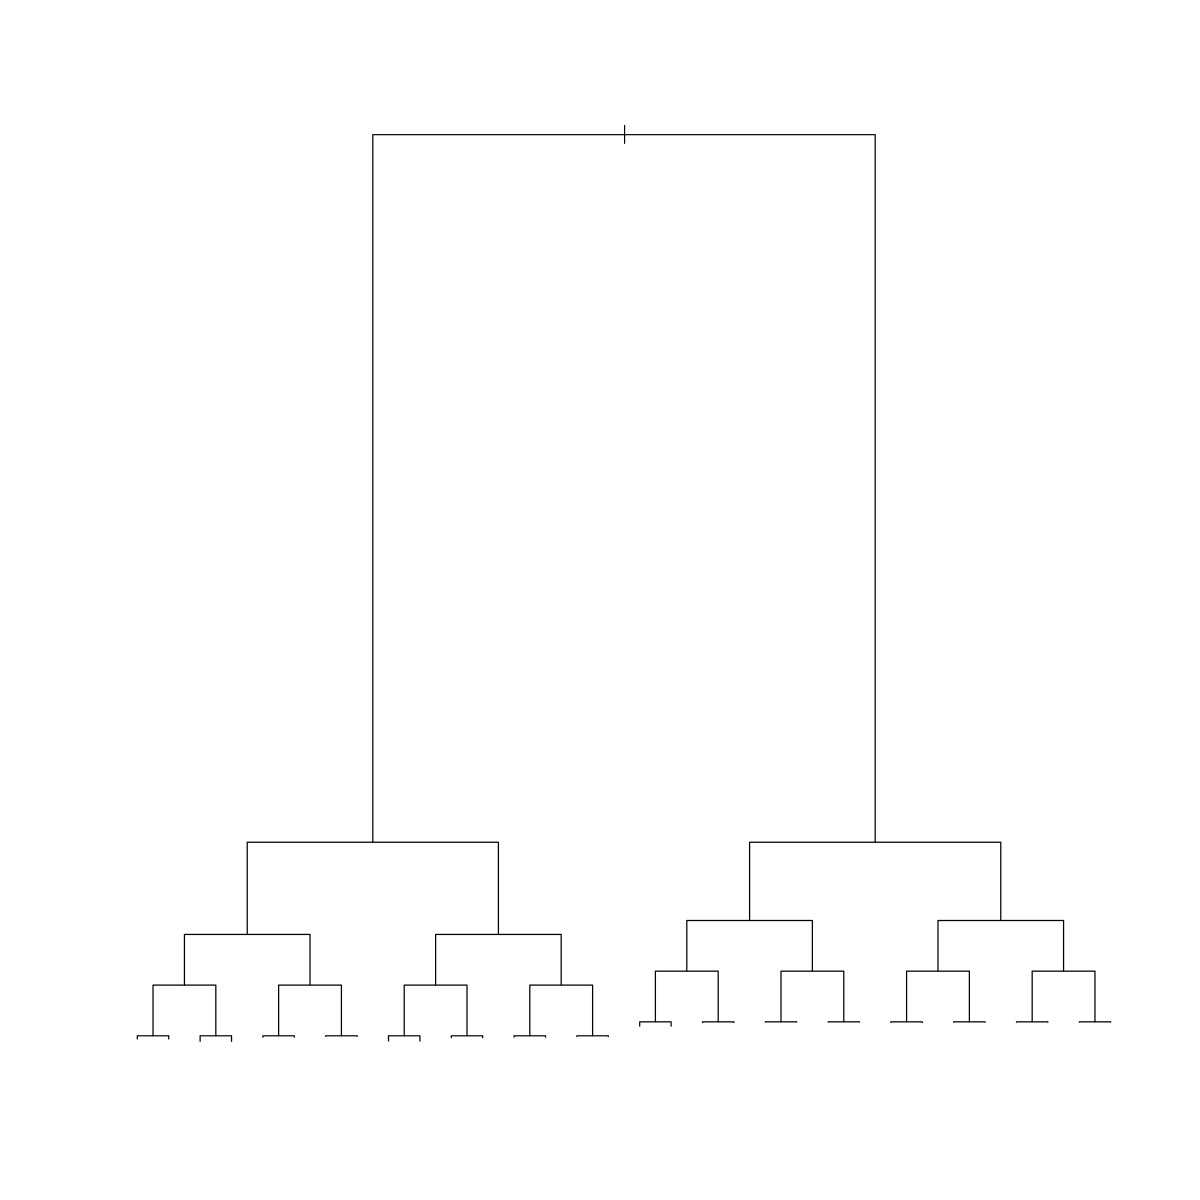

In [ ]:
best.tree.cont <- build.cardiotree(best.depth.cont, cat=FALSE, plot=FALSE, info=TRUE, testacc=FALSE)
plot(best.tree.cont)

In the table below it can be observed which are the features that matter the most in the costruction of the Decision Tree.

In [ ]:
imp.df.cont <- best.tree.cont$variable.importance %>% data.frame() 
colnames(imp.df.cont) <- "importance" 
imp.df.cont

,importance
,<dbl>
ap_hi,2.497991e+03
ap_lo,1.411735e+03
cholesterol,5.192637e+02
age_year,5.049152e+02
weight,2.964482e+02
gluc,1.272343e+02
active,6.638877e+00
height,6.453308e+00
gender,8.062083e-01


A ROC curve represents the relationship between the True Positive Rate (TPR) and the False Positive Rate (FPR) computed respect a varying threshold of a certain distribution. With respect to the hypothesis "we are dealing with a patient with cardiovascular desease", TPR is defined as the number of true positives (in our case the number of real people with a desease that the tree classifies as unhealthy) over the number of real positives cases in the data (total number of real unhealty people), $TPR=\frac{TP}{P}$,  while FPR is defined as the number of false postives (the number of real people who don't have a desease that tree classifies as unhealty) over the number of real negatives cases in the data (total number of real healthy people), $FPR=\frac{FP}{N}$. 

The area under the ROC curve (AUC) is a measure of the goodness of the model.

AUC:  0.7910697 


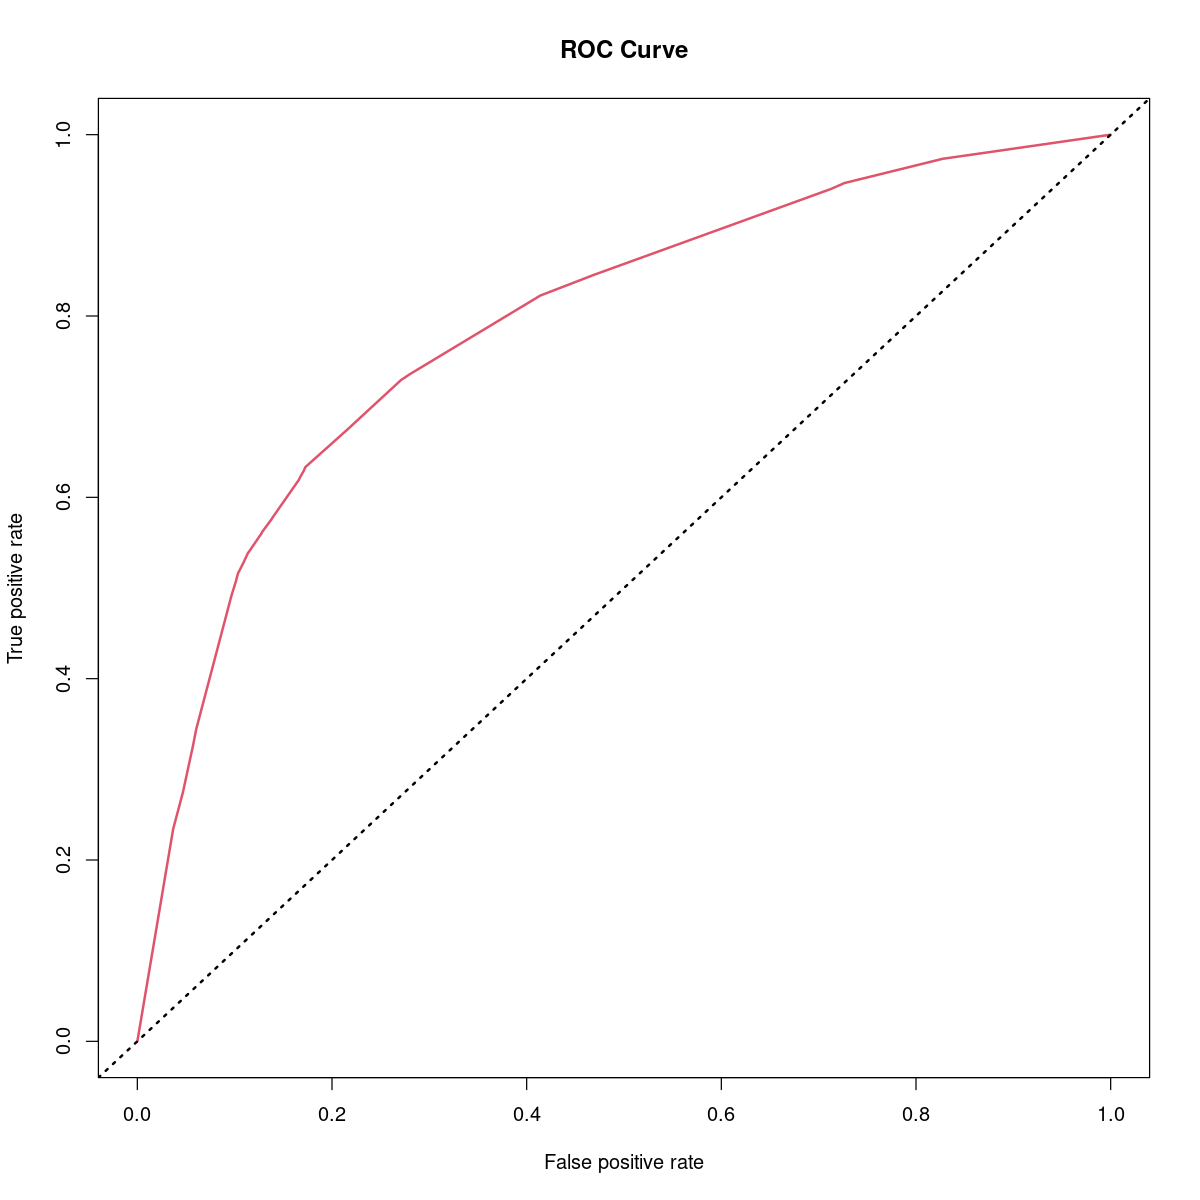

In [ ]:
best.tree.prediction.cont <- predict(best.tree.cont, testing.cont)
Prediction <- prediction(list(best.tree.prediction.cont),list(testing.cont$cardio))
performance <- performance(Prediction, "tpr","fpr")
aucDT <- performance(Prediction, measure = "auc")
aucDT <- aucDT@y.values[[1]]
cat("AUC: ", aucDT, "\n")

# plotting ROC curve
plot(performance, main = "ROC Curve", col = 2, lwd = 2)
abline(a = 0,b = 1,lwd = 2,lty = 3,col = "black")

### Random Forest
A Random Forest combines the results of several decision trees and assigns to an event the label that is predicted most frequently.
#### Categorical dataset
A Random Forest is constructed using $500$ trees and imposing a maximum number of nodes in a tree to the optimal value found in the previous section ($149$ in this case).

In [ ]:
rf.cardio <- randomForest(cardio~., data = data.cat, subset = train, importance=TRUE, ntree=500, maxnodes=149)


In [ ]:
rf.pred <- predict(rf.cardio, testing.cat)
cm=table(testing.cat$cardio, rf.pred )
cat("Confusion Matrix: ")
cm
cat("Accuracy: ", caret::confusionMatrix(rf.pred, testing.cat$cardio)$overall[['Accuracy']])

Confusion Matrix: 

     rf.pred
        No  Yes
  No  9302 2464
  Yes 3744 7823

Accuracy:  0.7339391

In the plot below it can be observed which are the features that matter the most in the costruction of the Random Forest.

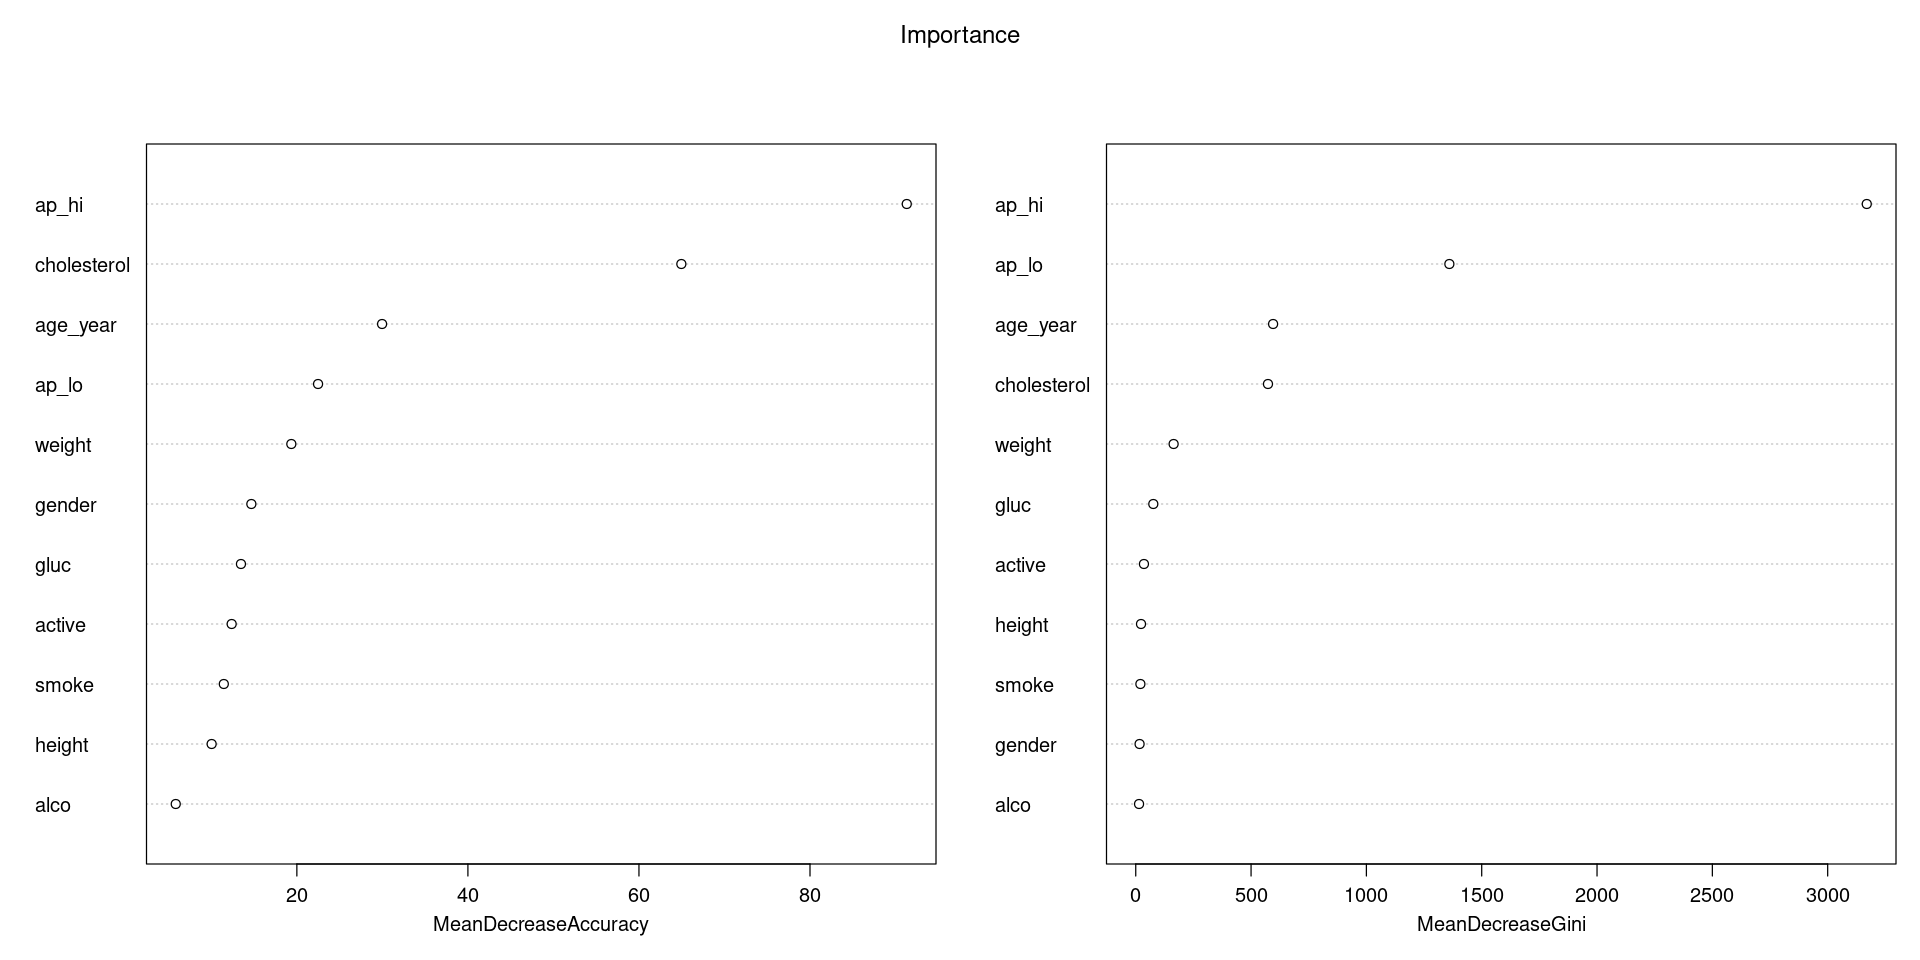

In [ ]:
options(repr.plot.width=16, repr.plot.height=8)
varImpPlot(rf.cardio, main="Importance")

### Continous Dataset

A Random Forest is constructed using $500$ trees and imposing a maximum number of nodes in a tree to the optimal value found in the previous section ($63$ in this case).

In [ ]:
data.train$cardio <- as.factor(as.character(data.train$cardio))
rf.cardio.cont <- randomForest(cardio~., data = data.train, subset = train, maxnodes=63, ntree=500)

In [ ]:
rf.pred.cont <- predict(rf.cardio.cont, testing.cont)
cm=table(testing.cont$cardio, rf.pred.cont)
cat("Confusion Matrix: ")
cm
cat("Accuracy: ",caret::confusionMatrix(rf.pred.cont, as.factor(testing.cont$cardio))$overall[['Accuracy']])


Confusion Matrix: 

   rf.pred.cont
       0    1
  0 9206 2560
  1 3692 7875

Accuracy:  0.7320533

In the plot below it can be observed which are the features that matter the most in the costruction of the Random Forest.

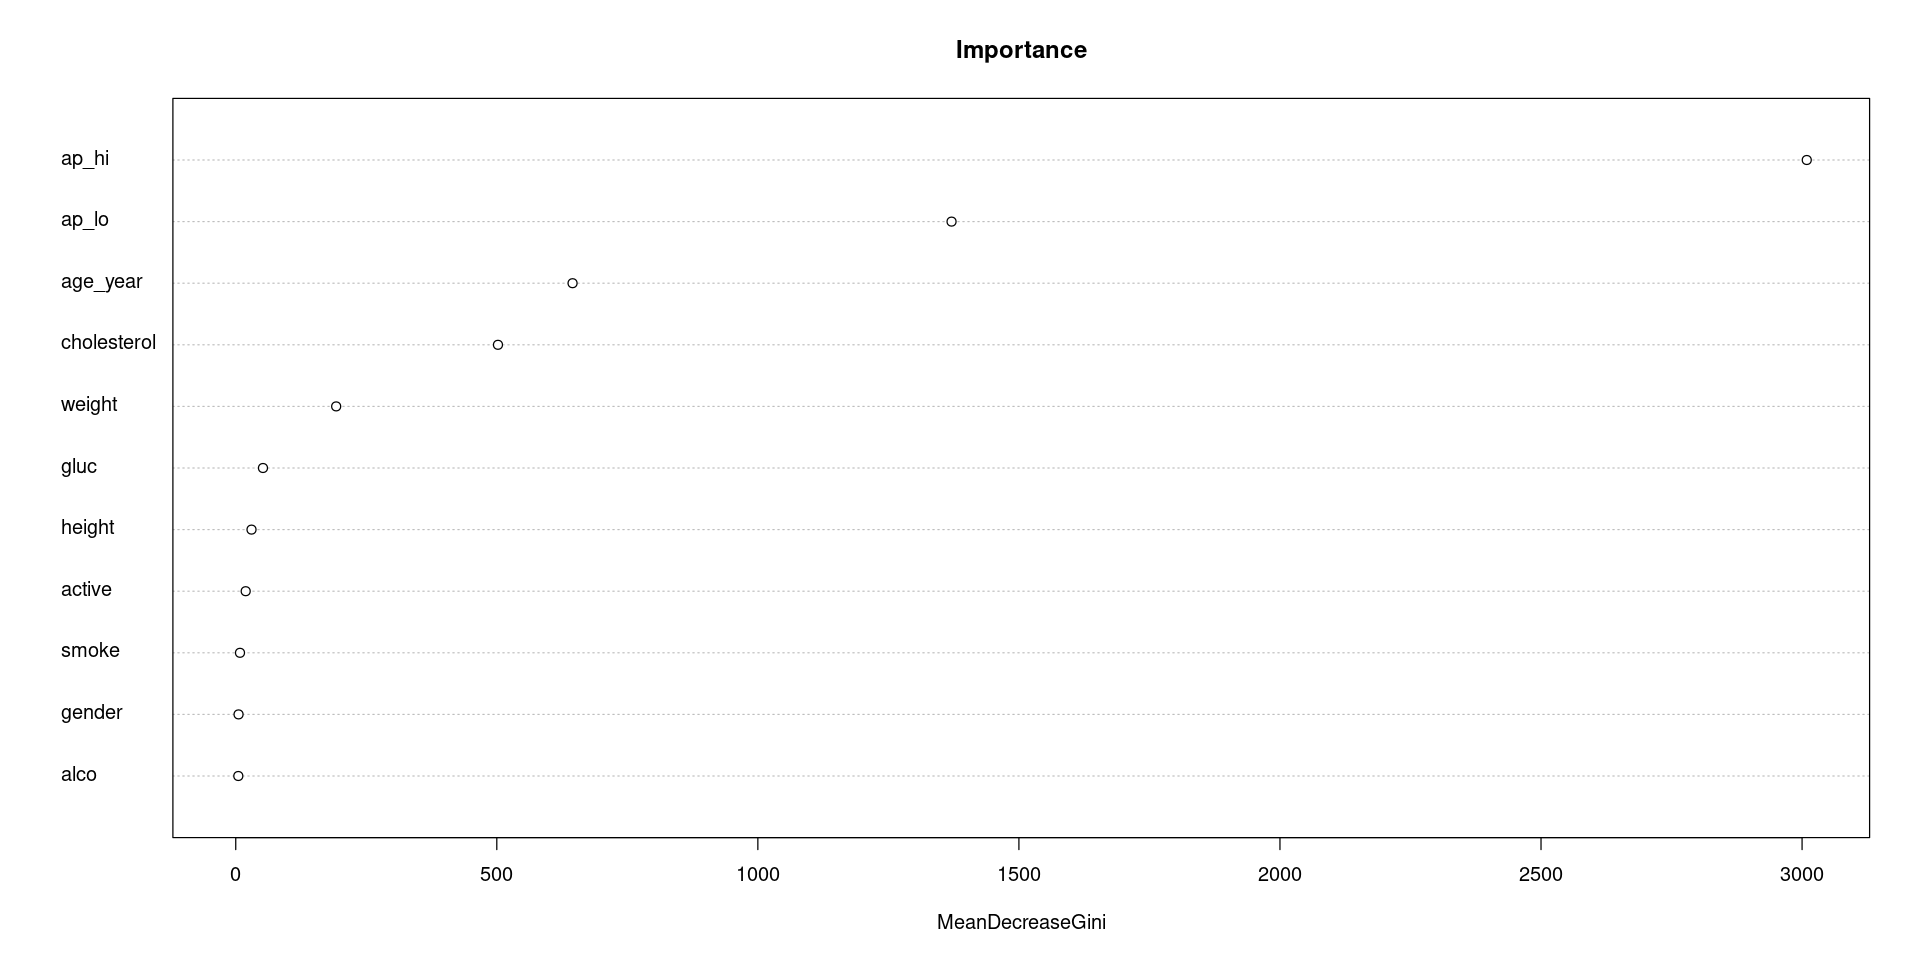

In [ ]:
varImpPlot(rf.cardio.cont, main="Importance")

# Conclusions

In the following table are reported the classification accuracies of the best Bayesian Network, Tree and Random Forest.

|| Categorical Dataset |Continous Dataset |
| :- | -: | :-: |
|  Best Bayesian Network | 0.7303 | 0.7294 
| Decision Tree | 0.7325 | 0.7312 
| Random Forest| 0.7339 | 0.7320


As we can see, the accuracies in the categorical case are slightly better than the continuous ones: this is probably due to the fact that tha majority of the varibles in our dataset are categorical. From the table we can also see that decision trees and especially random forest are better for calssification task with respect to the BN, although the differences are very small. The addition in using a BN instead of a classification tree is that the former can infer the values of more than one varible at a time, and not only the classification varible (`cardio` in our case). Moreover the BN are more suitable for new data samples generations and to infer the probability relations among the features of the dataset.

## References:

[1] https://www.kaggle.com/sulianova/cardiovascular-disease-dataset \
[2] Gregory F. Cooper, Edward Herskovits, A Bayesian Method for the Induction of Probabilistic Networks from Data, 1992 Kluwer Academic Publishers, Boston \
[3] Marco Scutari, Understanding Bayesian Networkswith Examples in R (https://dipartimenti.unicatt.it/scienze-statistiche-23-25-1-17ScutariSlides.pdf) \
[4] Carolina Ruiz, llustration of the K2 Algorithm for Learning Bayes Net Structures (http://web.cs.wpi.edu/~cs539/s11/Projects/k2_algorithm.pdf)